<a href="https://colab.research.google.com/github/hisunnytang/HaloEGNN/blob/main/notebooks/HaloEGNN_MarginalDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the neccessary package

In [ ]:
%%capture
!pip install torchdiffeq
!pip install gdown
!git clone https://github.com/hisunnytang/HaloEGNN.git
!pip install -U emcee

In [ ]:
import numpy as np
import torch
import glob
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
import pickle
from HaloEGNN.HaloEGNNFlows.EGNNFlows.models import get_model
from HaloEGNN.HaloEGNNFlows.EGNNFlows.datasets import \
(
 ProgenitorDataset,
 find_closest_redshift_slice, 
 prepare_input_data
 )

from HaloEGNN.HaloEGNNFlows.EGNNFlows.viz.utils import compute_metric_features
from HaloEGNN.HaloEGNNFlows.EGNNFlows.flows.utils import assert_correctly_masked, assert_mean_zero_with_mask
from HaloEGNN.HaloEGNNFlows.EGNNFlows.flow_forward import  flow_forward
from HaloEGNN.HaloEGNNFlows.train import prepare_filelist_and_transformer
import re
from collections import OrderedDict

# Copy the preprocessed data and Model Checkpoint

In [ ]:
!cp /content/drive/MyDrive/HaloEGNN_sample_data/newdata.zip .
!cp /content/drive/MyDrive/HaloEGNN_sample_data/38734815.gadi-pbs.zip .
!cp /content/drive/MyDrive/HaloEGNN_sample_data/38707245.gadi-pbs.zip .

In [ ]:
%%capture 
!unzip newdata.zip
!unzip 38707245.gadi-pbs.zip
!unzip 38734815.gadi-pbs.zip

# Retrieve The Model and Load Checkpoint

In [ ]:
# The "scalar" feature bounded to the progenitors
feature_columns = ["SubhaloMass", "SubhaloMergeRedshift"]
# The "positional" feature bounded to the progenitors
position_columns = ["SubhaloPos_0", "SubhaloPos_1", "SubhaloPos_2"]

# initialize the list condtional columns at redshift 0
condition_columns = [
    "SubhaloBHMass",
    "SubhaloBHMdot",
    "SubhaloGasMetallicity",
    "SubhaloStarMetallicity",
    "SubhaloMass",
    "SubhaloSFR",
    "SubhaloVmax",
    "SubhaloVelDisp",
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_dims = len(position_columns)
in_node_nf = len(feature_columns)
context_node_nf = len(condition_columns)

prior, flow = get_model(
    in_node_nf=in_node_nf, 
    dynamics_in_node_nf=1, 
    context_node_nf=context_node_nf, 
    n_dims=3, 
    device=device)


ckpt_path = "38734815.gadi-pbs/egnn_26_val=22.829.pt"
# ckpt_path = "38707245.gadi-pbs/egnn_46_val=44.325.pt"

ckpt = torch.load(ckpt_path, map_location=device)

state_dict = ckpt['model_state_dict']

model_dict = OrderedDict()
pattern = re.compile('module.')
for k,v in state_dict.items():
    if re.search("module", k):
        model_dict[re.sub(pattern, '', k)] = v
    else:
        model_dict[k] = v
flow.load_state_dict(model_dict)

<All keys matched successfully>

# Load the Dataset and perform normalization on the conditional

In [ ]:
filelist = sorted(glob.glob("TNG300_preprocessed_data/prog_sublink_*.npy"))
data_columns = np.load("TNG300_preprocessed_data/subhalo_columns.npy")
max_progenitors = 20
initial_slice = 0
final_slice = 1

# The "scalar" feature bounded to the progenitors
feature_columns = ["SubhaloMass", "SubhaloMergeRedshift"]
# The "positional" feature bounded to the progenitors
position_columns = ["SubhaloPos_0", "SubhaloPos_1", "SubhaloPos_2"]

# initialize the list condtional columns at redshift 0
condition_columns = [
    "SubhaloBHMass",
    "SubhaloBHMdot",
    "SubhaloGasMetallicity",
    "SubhaloStarMetallicity",
    "SubhaloMass",
    "SubhaloSFR",
    "SubhaloVmax",
    "SubhaloVelDisp",
]

n_dims = len(position_columns)
in_node_nf = len(feature_columns)
context_node_nf = len(condition_columns)


valid_files, condition_normalizer = prepare_filelist_and_transformer(
    filelist_npy=None,
    transformer_pkl=None,
    filelist=filelist,
    condition_columns=condition_columns,
    full_columns_names=data_columns,
    max_progenitors=20,
    initial_slice=0,
    final_slice=1,
    batch_size=512,
    num_workers=2,
    transform_type = "power"
)


dataset = ProgenitorDataset(
        valid_files,
        condition_columns=condition_columns,
        position_columns=position_columns,
        feature_columns=feature_columns,
        max_progenitors=max_progenitors,
        initial_slice=initial_slice,
        final_slice=final_slice,
        data_columns=data_columns,
    )

# tiny snippet to transform redshift to scale factor
def transform_z_to_scale(z_idx):
    def transform_graph(input_graph):
        # transform only the features
        if z_idx is None:
            return input_graph
        x, h, node_mask, edge_mask = input_graph
        h[:, :, z_idx] = 1 / (1 + h[:, :, z_idx])
        h[:, :, z_idx] = h[:, :, z_idx].exp()
        return x, h, node_mask, edge_mask
    return transform_graph
zidx = None
if "SubhaloMergeRedshift" in feature_columns:
    zidx = feature_columns.index("SubhaloMergeRedshift")
transform_input = transform_z_to_scale(zidx)

def preprocess_inputs(ds, idx):
  # select only one element! 
  # from the dataset by index
  tmp1, tmp2 = ds[idx]
  input_graph = [t.unsqueeze(0) for t in tmp1]
  input_graph = transform_input(input_graph)
  input_cond  = [torch.from_numpy(condition_normalizer.transform(t.unsqueeze(0))) for t in tmp2]
  return input_graph, input_cond

In [ ]:
dataset = ProgenitorDataset(
        sorted(valid_files),
        condition_columns=condition_columns,
        position_columns=position_columns,
        feature_columns=feature_columns,
        max_progenitors=max_progenitors,
        initial_slice=initial_slice,
        final_slice=final_slice,
        data_columns=data_columns,
    )

# Verify the model and data are properly loaded
- perform the validation step
- with cpu, it might take a while to run...
- stop it once the val loss looks alright?
- better still run it with cuda?
- the current ckpt has a val loss of ~22.8

In [ ]:
from HaloEGNN.HaloEGNNFlows.train import *
dl_train, dl_val, dl_test = prepare_dataloaders(
    sorted(valid_files),
    condition_columns,
    data_columns,
    position_columns=position_columns,
    feature_columns=feature_columns,
    max_progenitors=20,
    initial_slice=0,
    final_slice=1,
    batch_size=1,
    num_workers=0,
    random_seed=42,
    train_test_split=[0.8, 0.1, 0.1],
    shuffle_train=True,
    distributed=False,
)

val_step(flow, prior, dl_val, condition_normalizer, device="cpu", ode_regularization=1e-2, transform_input=transform_input)

 13%|█▎        | 987/7607 [10:37<1:11:17,  1.55it/s, val_loss=21.5, nll=14.7]


KeyboardInterrupt: ignored

# Group the data into one big dataframe
- `dfcond` is the dataframe with the conditional vector for each z = 0 galaxy
- `dffeat` is the statistics for the corresponding halo progenitors
- `feat_max_progenitors` limits the maximum number of progenitor included in this dataframe construction

In [ ]:
from HaloEGNN.HaloEGNNFlows.EGNNFlows.viz.utils import obtain_feature_df
dfcond, dffeat = obtain_feature_df(
    filelist,
    # sorted(valid_files),
    condition_columns,
    feature_columns=["SubhaloMass","SubhaloMergeRedshift"],
    initial_slice=0,
    final_slice=1,
    max_progenitors=20,
    max_samples=100000,
    distance_norm=300,
    full_columns_names=data_columns,
    feat_max_progenitors=20,
)

# Units of these data
- these are all raw values from TNG300
- https://www.tng-project.org/data/docs/specifications/#sec2b
- BHMass = 10^10 Msun/h
- BHMdot = 10^10 Msun / 0.978 Gyr
- Mass = 10^10 Msun/h
- SFR. = M / yr
- Vmax = km/s
- Vdisp = km/s

In [ ]:
cond_minimum = dfcond[dfcond>0].min().to_frame().transpose().values
dfcond_padded = dfcond + cond_minimum*1e-2

# Sample Flow from a conditional vector
- prior is just gaussian normal multi-d
- flow is our trained model
- note that the context is the conditional vector, and is assumed to be normalized already
- node_mask implicity specifies the number of nodes used for generation

P (c | G)

normalizing flow: P(G | c) P (c) = P(G,c)

In [ ]:
dataset = ProgenitorDataset(
        filelist,
        condition_columns=condition_columns,
        position_columns=position_columns,
        feature_columns=feature_columns,
        max_progenitors=max_progenitors,
        initial_slice=initial_slice,
        final_slice=final_slice,
        data_columns=data_columns,
    )

In [ ]:
input_graph, input_cond = preprocess_inputs(  dataset , 9826)

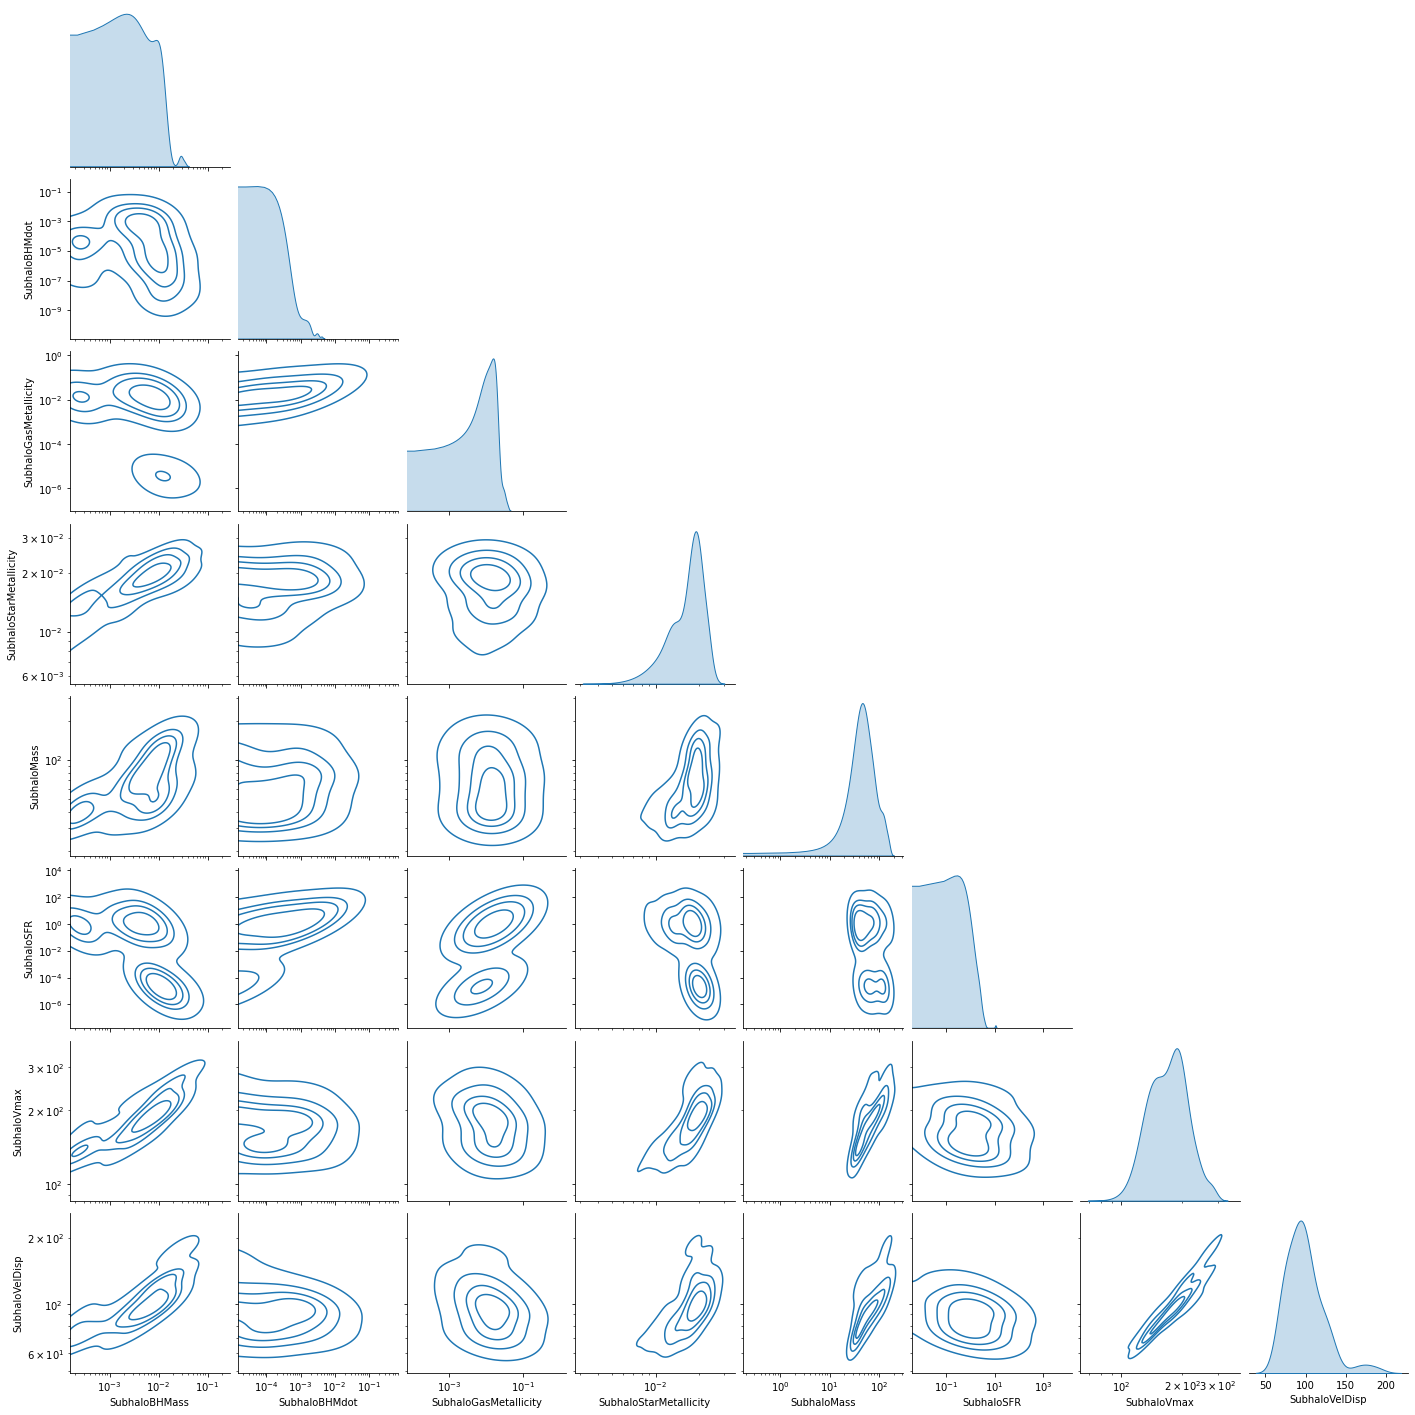

In [ ]:
g = sns.pairplot(
    dfcond_padded.sample(100), 
    # vars = ['SubhaloMass','SubhaloSFR'],
    kind='kde', 
    plot_kws={'log_scale':True, 'levels': 5},
    corner=True
    )


def overlay_conditional(g, input_cond, color='C1'):
  for i in range(8):
    for j in range(8):
      if i > j:
        g.axes[i][j].scatter(
            input_cond[0][j], 
            input_cond[0][i], 
            s=500, 
            marker='*', 
            color=color
            )
  return g

In [ ]:
def sample_from_flows_with_context(prior, 
                                   flow, 
                                   node_mask,
                                   context=torch.tensor([[0.]]), 
                                   context_transform= None,
                                   device='cpu'):
  
  # prepare context
  n_samples, n_nodes, n_context = node_mask.shape
  # prepare a node mask, for now we assume its all visible
  node_mask = node_mask.to(device)

  if context_transform is not None:
    context = torch.from_numpy(context_transform(context)).unsqueeze(1)

  context_ = context.to(device)
  context_ = context_.repeat(1,n_nodes,1)*node_mask
  assert_correctly_masked(context_, node_mask)

  edge_mask = (1 - torch.eye(n_nodes)).unsqueeze(0)
  edge_mask = edge_mask.repeat(n_samples, 1, 1).view(1, -1).to(device)

  print(node_mask.shape, edge_mask.shape)
  # return node_mask, edge_mask
  with torch.no_grad():
    z_x, z_h = prior.sample(n_samples, n_nodes, node_mask)
    z = torch.cat([z_x, z_h], dim=2)
    tmp = flow.reverse(z, node_mask, edge_mask, context_.float())
    x    = tmp[:, :, 0:3].cpu()
    feat = tmp[:, :, 3:].cpu()
  return x, feat

In [ ]:
dfcond.sample(5)

SubhaloBHMass  SubhaloBHMdot  SubhaloGasMetallicity  \
48125       0.017975   1.341968e-08               0.000000   
17996       0.002844   1.364965e-04               0.020385   
45299       0.001991   4.365093e-06               0.016874   
20363       0.009605   1.595064e-07               0.016258   
53058       0.000230   2.834706e-06               0.016605   

       SubhaloStarMetallicity  SubhaloMass  SubhaloSFR  SubhaloVmax  \
48125                0.017579   107.776878    0.000000   240.800339   
17996                0.015407   113.779030    1.553724   171.276749   
45299                0.020737    66.910202    0.018268   182.960159   
20363                0.021275    39.692528    0.000000   193.593185   
53058                0.015298    40.882816    1.751423   165.322678   

       SubhaloVelDisp  
48125      141.072708  
17996       96.884567  
45299       94.384232  
20363       96.379158  
53058       83.141617

In [ ]:
mass_cols = [f"SubhaloMass_{m}" for m in range(20)] 
rows_with_10_prog = (dffeat[mass_cols] == 0).sum(axis=1) <= 15
print(rows_with_10_prog.sum())

75550


torch.Size([2048, 20, 1]) torch.Size([1, 819200])


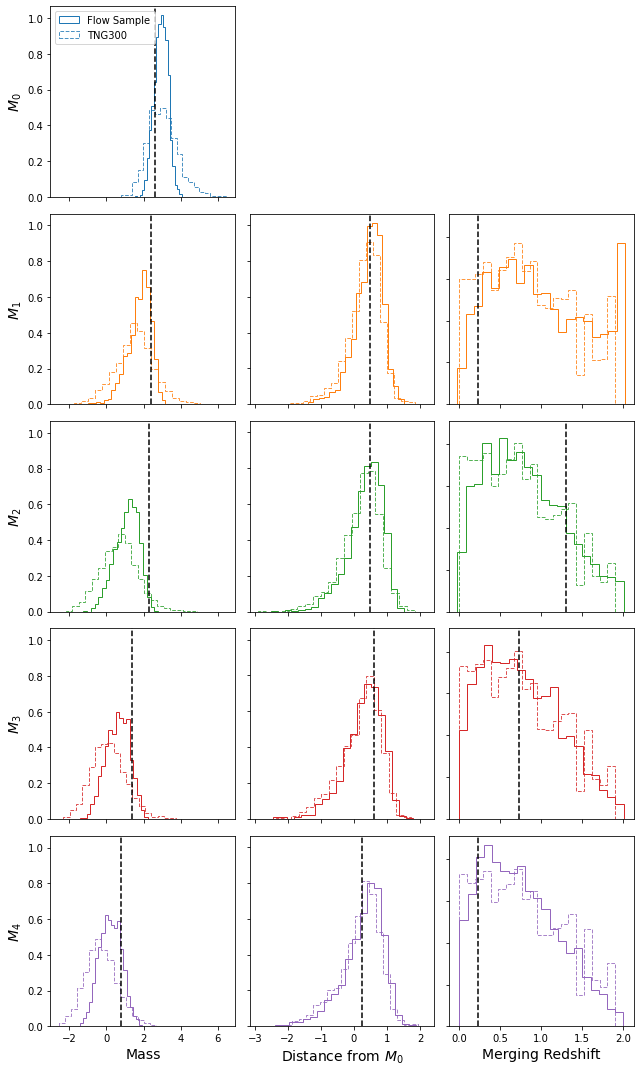

In [ ]:
import matplotlib.pyplot as plt
import torch

# Select
# input_graph, input_cond = dataset[52312]


# input_graph, input_cond = dataset[52312]

# input_graph, input_cond = dataset[7051]

input_graph, input_cond = dataset[9826]

cond_norm = torch.from_numpy(
    condition_normalizer.transform([input_cond[0].numpy()])
    )

nnodes = input_graph[2].sum().item()
node_mask = torch.ones(2048,nnodes,1)
xpos, feat = sample_from_flows_with_context(prior, flow, node_mask, cond_norm)

nbins = 20


Msample_sorted, Msample_sorted_idx = torch.sort(
    feat[:,:,0], 
    dim=1, 
    descending=True)
x_sort_by_mass = torch.stack(
  [x[idx] for x, idx in zip(xpos, Msample_sorted_idx)]
)

feat_sorted_by_mass = torch.stack(
  [x[idx] for x, idx in zip(feat, Msample_sorted_idx)]
)


metrics, _cols = compute_metric_features(
    x_sort_by_mass, 
    feat_sorted_by_mass, 
    max_prog=5, 
    column_names=['m','z']
)

_metrics_df = pd.DataFrame(metrics,columns=_cols)

f,axes = plt.subplots(
    5,3,
    sharey='col', 
    sharex='col', 
    figsize=(9,15),)
for i in range(1,5):
  _metrics_df[f'd0{i}'].apply(np.log10).plot.hist(
      bins=nbins, 
      density=True,
      histtype='step',
      ax=axes[i][1],
      color=f'C{i}'
      )
  dffeat[rows_with_10_prog][[f'd0{i}']].sample(len(_metrics_df)).apply(np.log10).plot.hist(
      ax=axes[i][1],
      alpha=0.8,
      bins=nbins, 
      density=True,
      histtype='step', 
      color=f'C{i}', 
      ls='--'
      )
  
  axes[i][1].get_legend().remove()


for i in range(5):
  _metrics_df[f'm_{i}'].plot.hist(
      bins=nbins, 
      density=True,
      histtype='step', 
      color=f'C{i}',
      ax=axes[i][0],
      label='Flow Sample'
      )
  dffeat[rows_with_10_prog][f'SubhaloMass_{i}'].sample(len(_metrics_df)).apply(np.log).plot.hist(
      ax=axes[i][0],
      alpha=0.8,
      bins=nbins, 
      density=True,
      histtype='step', 
      ls='--', 
      color=f'C{i}',
      label='TNG300'
      )
  
  if i == 0:
    axes[0][0].legend()
  # else:
  #   axes[i][0].get_legend().remove()
  # else:
    

for i in range(1,5):
  _metrics_df[f'z_{i}'].apply(lambda a: 1/a - 1).plot.hist(
      bins=nbins, 
      density=True,
      histtype='step', 
      color=f'C{i}',
      ax=axes[i][2])
  dffeat[rows_with_10_prog][[f'SubhaloMergeRedshift_{i}']].plot.hist(
      ax=axes[i][2],
      alpha=0.8,
      bins=nbins, 
      density=True,
      histtype='step', 
      ls='--', 
      color=f'C{i}')
  axes[i][2].get_legend().remove()

for i in range(5):
  axes[i][0].set_ylabel(f"$M_{i}$", fontsize=14)


axes[-1][0].set_xlabel("Mass", fontsize=14)
axes[-1][1].set_xlabel(r"Distance from $M_0$", fontsize=14)
axes[-1][2].set_xlabel(r"Merging Redshift", fontsize=14)

axes[0][1].axis('off')
axes[0][2].axis('off')


input_graph[0]

for i in range(5):
  axes[i][0].axvline(input_graph[1][i,0].log(), color='k', ls='--')

for i in range(1,5):
  axes[i][2].axvline(input_graph[1][i,1], color='k', ls='--')


for i in range(1,5):
  d0i = (( (input_graph[0][i,:] - input_graph[0][0,:]) /300)**2).sum().log10() 
  axes[i][1].axvline( d0i , color='k', ls='--')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
f.savefig("PointDistribution.png")

In [ ]:
# matches the number of progenitors!
rows_with_nnodes = (dffeat[mass_cols] == 0).sum(axis=1) == 0
_metrics_df   = pd.DataFrame(metrics,columns=_cols)
_marginal_df  = dffeat[rows_with_nnodes].copy(deep=True)
# _marginal_df.columns

In [ ]:
rename_dict = {}
for c in _marginal_df.columns:
  if c.startswith('SubhaloMass'):
    i = c.split('_')[1]
    rename_dict[c] = f"m_{i}"
  elif c.startswith('SubhaloMergeRedshift'):
    i = c.split('_')[1]
    rename_dict[c] = f"z_{i}"
_marginal_df.rename(columns=rename_dict, inplace=True)

In [ ]:
mcols = [c for c in _marginal_df.columns if c.startswith('m')]
_marginal_df.loc[:,mcols] = np.log(_marginal_df.loc[:,mcols])

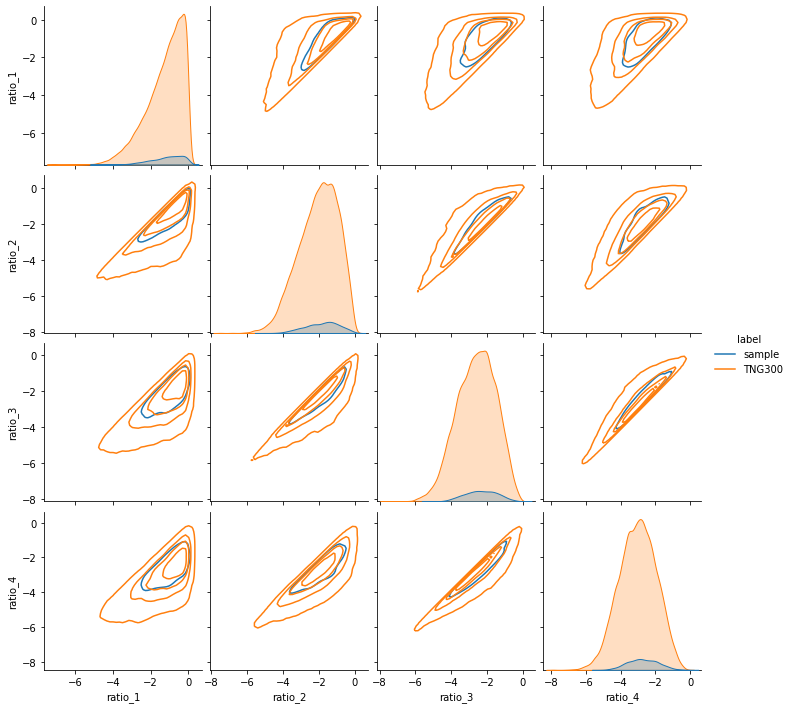

In [ ]:
_marginal_df = _marginal_df.loc[:,_metrics_df.columns]

def get_mass_ratio(df,):

  prefix = "m"
  m0 = f"{prefix}_0"
  if m0 not in df.columns:
    m0 = "SubhaloMass_0"
    prefix = "SubhaloMass"

  for i in range(1,5):
    mi = f"{prefix}_{i}"
    df[f'ratio_{i}'] = df[mi] - df[m0]

get_mass_ratio(_metrics_df)
get_mass_ratio(_marginal_df)


ratio_cols = [f"ratio_{i}" for i in range(1,5)]

_metrics_df['label'] = "sample"
_marginal_df['label'] = "TNG300"

_df = pd.concat([_metrics_df, _marginal_df], ).reset_index(drop=True)

sns.pairplot(_df, vars=ratio_cols, hue='label', kind='kde', plot_kws={'levels':5, 'gridsize': 50})

In [ ]:
def find_extrema(df, col = 'd'):
  dcols = [c for c in df.columns if c.startswith(col)]

  dmax = -999999999
  dmin = 9999999999

  for c in dcols:
    _max = df[c].max()
    _min = df[c].min()
    dmax = max(_max, dmax)
    dmin = min(_min, dmin)
  return dmin-0.2, dmax+0.2

def find_local_extrema(df, col = 'd'):
  _max = df[col].max()
  _min = df[col].min()
  return _min-0.1, _max+0.1

In [ ]:
def convert_units(df, logd = True, a_to_z=True):
  _df = df.copy(deep=True)
  
  zcol = [c for c in df.columns if c.startswith('z')]
  dcol = [c for c in df.columns if c.startswith('d')]

  if logd:
    for c in dcol:
      _df[c] = np.log10(_df[c])

  if a_to_z:  
    for c in zcol:
      _df[c] = 1/_df[c] - 1
  return _df

In [ ]:
_norm_metrics_df = convert_units(_metrics_df)
_norm_marginal_df = convert_units(_marginal_df, a_to_z=False)

In [ ]:
dmin, dmax = find_extrema(_norm_metrics_df, col='d')
zmin, zmax = find_extrema(_norm_metrics_df, col='z')
rmin, rmax = find_extrema(_norm_metrics_df, col='ratio')
mmin, mmax = find_extrema(_norm_metrics_df, col='m')

extent = {
    'd':[dmin,dmax],
    'z':[zmin,zmax],
    'r':[rmin,rmax],
    'm':[mmin,mmax]
}

In [ ]:
pretty_name = {}
for i in range(6):
  pretty_name[f'm_{i}'] = f'$M_{{{i}}}$'
  pretty_name[f'z_{i}'] = f'$z_{{{i}}}$'
  pretty_name[f'ratio_{i}'] = f'$M_{{{i}}} / M_0$'
  for j in range(i+1,6):
    pretty_name[f'd{i}{j}'] = f"$d_{{ {i} {j} }}$"

pretty_name

{'m_0': '$M_{0}$',
 'z_0': '$z_{0}$',
 'ratio_0': '$M_{0} / M_0$',
 'd01': '$d_{ 0 1 }$',
 'd02': '$d_{ 0 2 }$',
 'd03': '$d_{ 0 3 }$',
 'd04': '$d_{ 0 4 }$',
 'd05': '$d_{ 0 5 }$',
 'm_1': '$M_{1}$',
 'z_1': '$z_{1}$',
 'ratio_1': '$M_{1} / M_0$',
 'd12': '$d_{ 1 2 }$',
 'd13': '$d_{ 1 3 }$',
 'd14': '$d_{ 1 4 }$',
 'd15': '$d_{ 1 5 }$',
 'm_2': '$M_{2}$',
 'z_2': '$z_{2}$',
 'ratio_2': '$M_{2} / M_0$',
 'd23': '$d_{ 2 3 }$',
 'd24': '$d_{ 2 4 }$',
 'd25': '$d_{ 2 5 }$',
 'm_3': '$M_{3}$',
 'z_3': '$z_{3}$',
 'ratio_3': '$M_{3} / M_0$',
 'd34': '$d_{ 3 4 }$',
 'd35': '$d_{ 3 5 }$',
 'm_4': '$M_{4}$',
 'z_4': '$z_{4}$',
 'ratio_4': '$M_{4} / M_0$',
 'd45': '$d_{ 4 5 }$',
 'm_5': '$M_{5}$',
 'z_5': '$z_{5}$',
 'ratio_5': '$M_{5} / M_0$'}

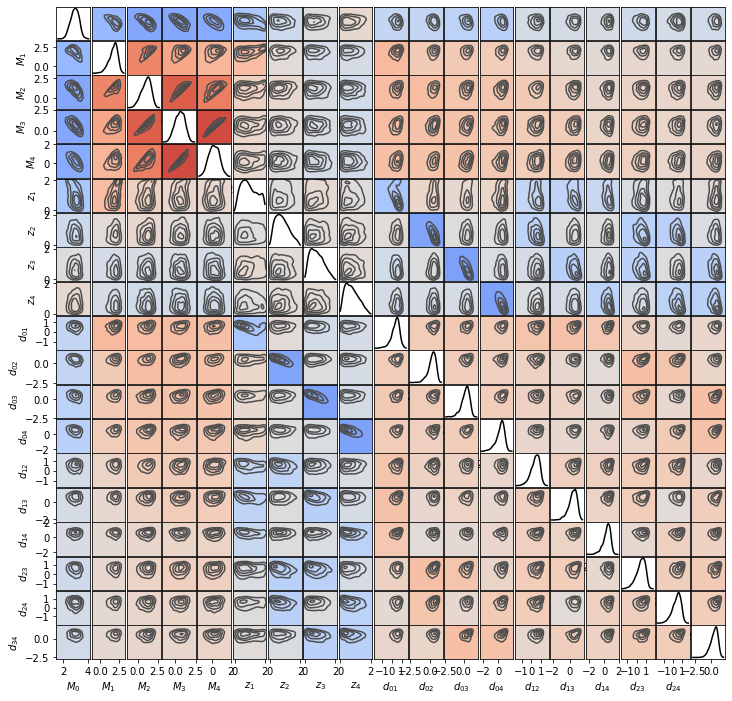

In [ ]:
import scipy.stats as stats
import matplotlib.colors as colors
import matplotlib


def plot_off_diag(ax, xvals, yvals, x_extent, y_extent, gridsize=100):
  values = np.vstack([xvals,yvals])
  X, Y = np.mgrid[x_extent[0]:x_extent[1]:gridsize*1j ,y_extent[0]:y_extent[1]:gridsize*1j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  kernel = stats.gaussian_kde(values)
  Z = kernel(positions).reshape(gridsize,gridsize)
  Z = np.maximum(Z, 1e-20)
  ax.contour(
      Z.T,
      # cmap=plt.cm.gist_earth_r,
      extent=[
          x_extent[0], x_extent[1], 
          y_extent[0], y_extent[1]
          ],
      colors='0.3',
      levels= 4,
  )
  # explicitly set the xlim, ylim
  ax.set_xlim(*x_extent)
  ax.set_ylim(*y_extent)

  xdiff = x_extent[1] - x_extent[0]
  ydiff = y_extent[1] - y_extent[0]
  ax.set_aspect(xdiff/ydiff)

  return Z

def plot_diag(ax, xvals, x_extent, gridsize=100):
  values = xvals
  positions =  np.linspace(x_extent[0], x_extent[1], gridsize)
  kernel = stats.gaussian_kde(values)
  Z = kernel(positions)
  Z = np.maximum(Z, 1e-20)
  ax.plot(positions, Z, color='k')
  # explicitly set the xlim, ylim
  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()

  xdiff = xmax-xmin
  ydiff = ymax-ymin
  ax.set_aspect(xdiff/ydiff)

  return Z




def get_extent_vals(colname, df, use_local_extent = True):
  colval    = df[colname].values
  if use_local_extent:
    colextent = find_local_extrema(df, colname)
  else:
    colextent = extent[colname[0]]
  return colval, colextent


plot_cols = [
    'm_0', 'm_1','m_2', 'm_3','m_4',#'m_5',
    # 'ratio_1','ratio_2','ratio_3',
    'z_1','z_2','z_3', 'z_4', #'z_5',
    'd01','d02','d03','d04',#'d05',
    'd12', 'd13','d14',#'d15',
    'd23','d24',#'d25',
    'd34',#'d35',
    #'d45'

    ]
nplots = len(plot_cols)
f, axes = plt.subplots(nplots, nplots, figsize=(12,12), )

for i, xcolname in enumerate(plot_cols):
  for j, ycolname in enumerate(plot_cols):
    ax = axes[j,i]
    xvals, xextent = get_extent_vals(xcolname ,_norm_metrics_df)
    if i == j: 
      plot_diag(ax, xvals, xextent, gridsize=100)
      ax.get_yaxis().set_visible(False)
      continue    
    
    yvals, yextent = get_extent_vals(ycolname ,_norm_metrics_df)

    plot_off_diag(ax, xvals, yvals, xextent, yextent, gridsize=100)

    corr = np.corrcoef(
        _norm_metrics_df[xcolname], 
        _norm_metrics_df[ycolname]
        )[0][1]
    # print(i,j,corr)

    norm = colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.cm.get_cmap('coolwarm')
    ax.set_facecolor(cmap(norm(corr)))

    if xcolname in pretty_name:
      ax.set_xlabel(pretty_name[xcolname])
    if ycolname in pretty_name:
      ax.set_ylabel(pretty_name[ycolname])

    if j != nplots - 1:
      ax.get_xaxis().set_visible(False)
    if i != 0:
      ax.get_yaxis().set_visible(False)

if ycolname in pretty_name:
  ax.set_ylabel(pretty_name[ycolname])

plt.subplots_adjust(hspace=0.02, wspace=0.02)
# f.colorbar(matplotlib.cm.ScalarMappable(norm,cmap))
# plt.tight_layout()

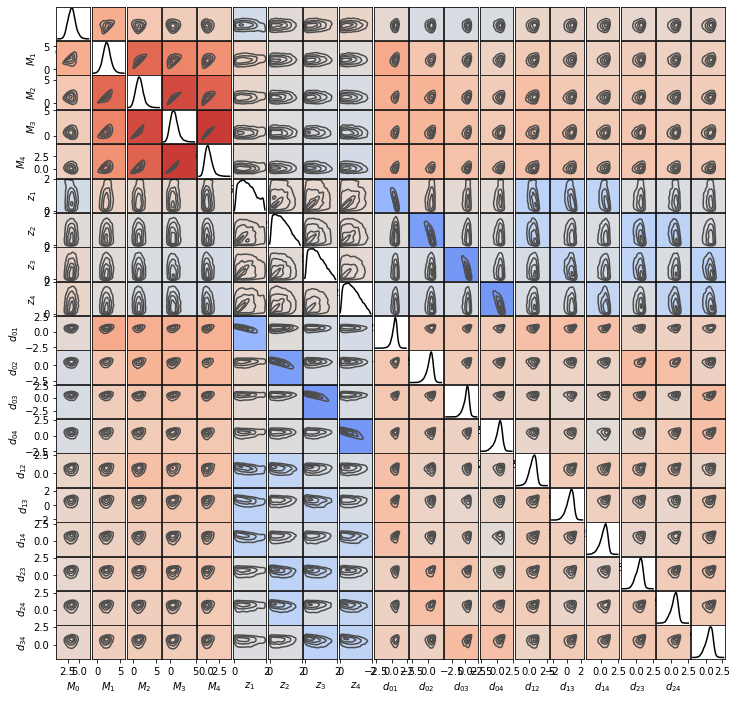

In [ ]:
import scipy.stats as stats
import matplotlib.colors as colors
import matplotlib


def plot_off_diag(ax, xvals, yvals, x_extent, y_extent, gridsize=100):
  values = np.vstack([xvals,yvals])
  X, Y = np.mgrid[x_extent[0]:x_extent[1]:gridsize*1j ,y_extent[0]:y_extent[1]:gridsize*1j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  kernel = stats.gaussian_kde(values)
  Z = kernel(positions).reshape(gridsize,gridsize)
  Z = np.maximum(Z, 1e-20)
  ax.contour(
      Z.T,
      # cmap=plt.cm.gist_earth_r,
      extent=[
          x_extent[0], x_extent[1], 
          y_extent[0], y_extent[1]
          ],
      colors='0.3',
      levels= 4,
  )
  # explicitly set the xlim, ylim
  ax.set_xlim(*x_extent)
  ax.set_ylim(*y_extent)

  xdiff = x_extent[1] - x_extent[0]
  ydiff = y_extent[1] - y_extent[0]
  ax.set_aspect(xdiff/ydiff)

  return Z

def plot_diag(ax, xvals, x_extent, gridsize=100):
  values = xvals
  positions =  np.linspace(x_extent[0], x_extent[1], gridsize)
  kernel = stats.gaussian_kde(values)
  Z = kernel(positions)
  Z = np.maximum(Z, 1e-20)
  ax.plot(positions, Z, color='k')
  # explicitly set the xlim, ylim
  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()

  xdiff = xmax-xmin
  ydiff = ymax-ymin
  ax.set_aspect(xdiff/ydiff)

  return Z




def get_extent_vals(colname, df, use_local_extent = True):
  colval    = df[colname].values
  if use_local_extent:
    colextent = find_local_extrema(df, colname)
  else:
    colextent = extent[colname[0]]
  return colval, colextent


plot_cols = [
    'm_0', 'm_1','m_2', 'm_3','m_4',#'m_5',
    # 'ratio_1','ratio_2','ratio_3',
    'z_1','z_2','z_3', 'z_4', #'z_5',
    'd01','d02','d03','d04',#'d05',
    'd12', 'd13','d14',#'d15',
    'd23','d24',#'d25',
    'd34',#'d35',
    #'d45'

    ]
nplots = len(plot_cols)
f, axes = plt.subplots(nplots, nplots, figsize=(12,12), )

for i, xcolname in enumerate(plot_cols):
  for j, ycolname in enumerate(plot_cols):
    ax = axes[j,i]
    xvals, xextent = get_extent_vals(xcolname ,_norm_marginal_df)
    if i == j: 
      plot_diag(ax, xvals, xextent, gridsize=100)
      ax.get_yaxis().set_visible(False)
      continue    
    
    yvals, yextent = get_extent_vals(ycolname ,_norm_marginal_df)

    plot_off_diag(ax, xvals, yvals, xextent, yextent, gridsize=100)

    corr = np.corrcoef(
        _norm_marginal_df[xcolname], 
        _norm_marginal_df[ycolname]
        )[0][1]
    # print(i,j,corr)

    norm = colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.cm.get_cmap('coolwarm')
    ax.set_facecolor(cmap(norm(corr)))

    if xcolname in pretty_name:
      ax.set_xlabel(pretty_name[xcolname])
    if ycolname in pretty_name:
      ax.set_ylabel(pretty_name[ycolname])

    if j != nplots - 1:
      ax.get_xaxis().set_visible(False)
    if i != 0:
      ax.get_yaxis().set_visible(False)

if ycolname in pretty_name:
  ax.set_ylabel(pretty_name[ycolname])

plt.subplots_adjust(hspace=0.02, wspace=0.02)
# f.colorbar(matplotlib.cm.ScalarMappable(norm,cmap))
# plt.tight_layout()

# Sample A Bunch of Progenitors

In [ ]:
input_graph, input_cond = dataset[52312]

cond_norm = torch.from_numpy(condition_normalizer.transform([input_cond[0].numpy()]))
# node_mask = input_graph[2].unsqueeze(0).repeat(2048,1,1)
nnodes = input_graph[2].sum().item()
node_mask = torch.ones(2048,nnodes,1)
xpos, feat = sample_from_flows_with_context(prior, flow, node_mask, cond_norm)

nbins = 20


Msample_sorted, Msample_sorted_idx = torch.sort(
    feat[:,:,0], 
    dim=1, 
    descending=True)
x_sort_by_mass = torch.stack(
  [x[idx] for x, idx in zip(xpos, Msample_sorted_idx)]
)

feat_sorted_by_mass = torch.stack(
    

    
  [x[idx] for x, idx in zip(feat, Msample_sorted_idx)]
)


metrics, _cols = compute_metric_features(
    x_sort_by_mass, 
    feat_sorted_by_mass, 
    max_prog=5, 
    column_names=['m','z']
)

_metrics_df = pd.DataFrame(metrics,columns=_cols)

torch.Size([2048, 6, 1]) torch.Size([1, 73728])


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
alpha=0.1

c0_rgba = matplotlib.colors.to_rgba_array("C0")[0]
c0_rgba_01 = c0_rgba*alpha + (1-alpha)* np.ones_like(c0_rgba)

c1_rgba = matplotlib.colors.to_rgba_array("C1")[0]
c1_rgba_01 = c1_rgba*alpha + (1-alpha)* np.ones_like(c1_rgba)

c3_rgba = matplotlib.colors.to_rgba_array("C3")[0]
c3_rgba_01 = c3_rgba*alpha + (1-alpha)* np.ones_like(c3_rgba)

def plot_pos_feat_3d(
    x, 
    feat, 
    fc = c0_rgba_01, 
    azim=-60, 
    elev=30, 
    scale_size=1, 
    alpha=0.5, 
    width = 2, 
    annotate=False, 
    grid_on=False, 
    size_pow=1/1.5, 
    return_fig=False, 
    vmax=2, 
    vmin=0.2, 
    logcolor=True,
    batch_idx = 0,
    ):
  # norm = matplotlib.colors.Normalize(vmin=0.2, vmax=2)
  if logcolor:
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
  else:
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
  cmap = matplotlib.cm.get_cmap('plasma')

  assert x.ndim == 3
  assert feat.ndim == 3
  
  X = x[batch_idx,:,0].copy()
  Y = x[batch_idx,:,1].copy()
  Z = x[batch_idx,:,2].copy()

  midx = feat[batch_idx,:,0].argmax()
  midx = 0
  X = X - X[midx]
  Y = Y - Y[midx]
  Z = Z - Z[midx]

  M = 0.1*(np.exp(feat[batch_idx,:,0]))**(size_pow) * scale_size
  z = 1/feat[batch_idx,:,1] - 1

  colors = cmap(norm(z))

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(azim, elev)

  
  ax.set_xlim(-width, width)
  ax.set_ylim(-width, width)
  ax.set_zlim(-width, width)

  if fc is not None:
    ax.set_facecolor(fc)
  #ax.xaxis.pane.set_edgecolor('#D0D0D0')
  ax.xaxis.pane.set_alpha(0)
  ax.yaxis.pane.set_alpha(0)
  ax.zaxis.pane.set_alpha(0)
  

  # Hide grid lines
  if not grid_on:
    ax.grid(False)
    ax._axis3don = False

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

  if annotate:
    anchor = np.array([-300,0,500])
    dx = np.array([1, 0, 0])
    dy = np.array([0, 1, 0]) 
    dz = np.array([0, 0, 1])

    dx = 100
    ax.plot(xs=[anchor[0], anchor[0]+ dx], ys = [anchor[1], anchor[1]], zs=[anchor[2], anchor[2]], color='k')
    ax.plot(xs=[anchor[0], anchor[0]], ys = [anchor[1], anchor[1]- dx], zs=[anchor[2], anchor[2]], color='k')
    ax.plot(xs=[anchor[0], anchor[0]], ys = [anchor[1], anchor[1]], zs=[anchor[2], anchor[2]+ dx], color='k')

    ax.text2D(0.25, 0.9, r"$\mathrm{100 ~  ckpc/h} $", transform=ax.transAxes, fontsize=20)

  # ax.plot(xs=[anchor[1], anchor[1]+ dx], ys = [anchor[2], anchor[2]], zs=anchor[0], zdir='y',color='k')
  # ax.plot(xs=[anchor[2], anchor[2]+ dx], ys = [anchor[0], anchor[0]], zs=anchor[1], zdir='x',color='k')

  # ax.plot(xs=[-6*100,-5*100], ys = [-6*100,-6*100], zs=-6*100, zdir='z',color='k')
  # ax.plot(ys=[-6*100,-5*100], xs = [-6*100,-6*100], zs=-6*100, zdir='y',color='k')
  # ax.plot(ys=[-6*100,-7*100], xs = [-6*100,-6*100], zs=-6*100, zdir='k',color='k')

  plots = []
  for i, j, k, s, c in zip(X, Y, Z, M, colors):
    # print(i,j,k,s,c)
    plots.append(draw_sphere(ax, i.item(), j.item(), k.item(), s.item(), c, rstride=5, cstride=5, alpha=alpha))
  # fig.colorbar(plots[-1])
  if not return_fig:
    plt.show()
    plt.close(fig)
  else:
    return fig

def draw_sphere(ax, x, y, z, size, color, rstride=2, cstride=2, alpha=0.3):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v))
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    # for i in range(2):
    #    ax.plot_surface(x+random.randint(-5,5), y+random.randint(-5,5), z+random.randint(-5,5),  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)

    return ax.plot_surface(x + xs, y + ys, z + zs, rstride=rstride, cstride=rstride, color=color, linewidth=0,
                    alpha=alpha, vmin=0.0, vmax=2.0)

In [ ]:
idx = 52312 # 6 nodes only

# idx =323
input_graph, input_cond  = preprocess_inputs(dataset,idx)

In [ ]:
input_graph[0].shape

torch.Size([20, 3])

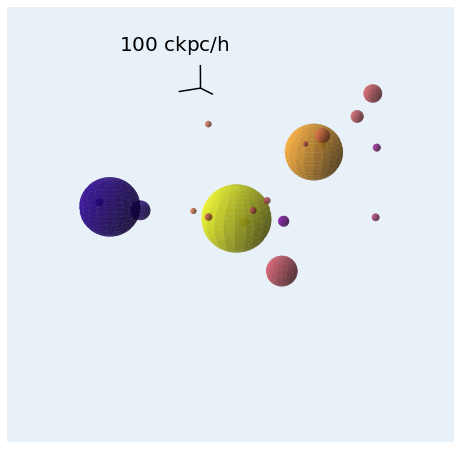

In [ ]:
# idx = 52312 # 6 nodes only

# idx =323


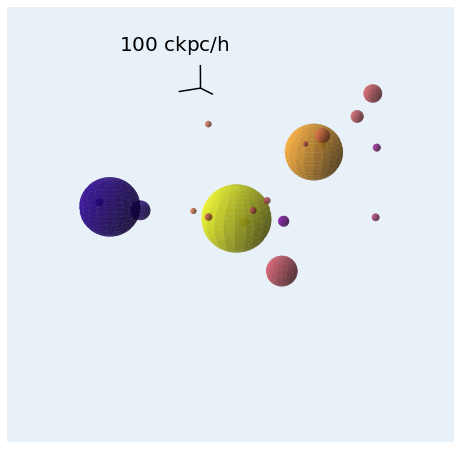

torch.Size([5, 20, 1]) torch.Size([1, 2000])


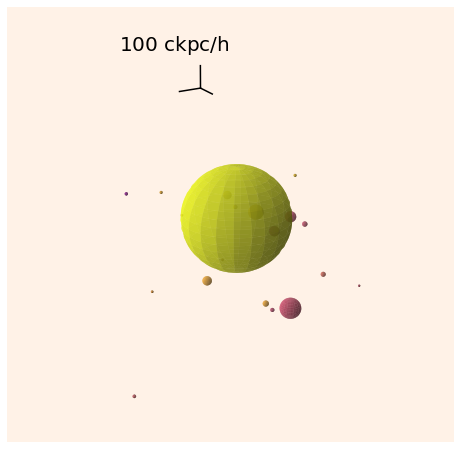

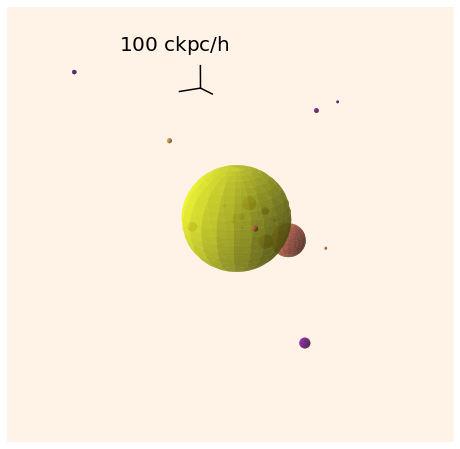

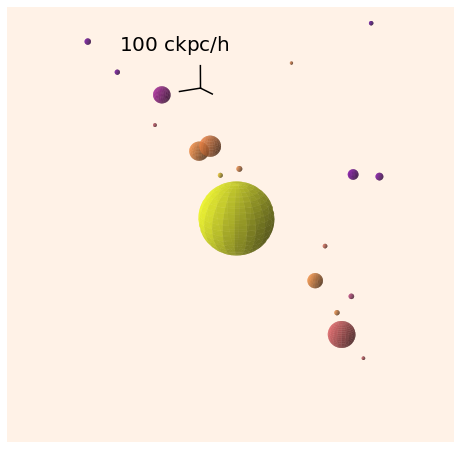

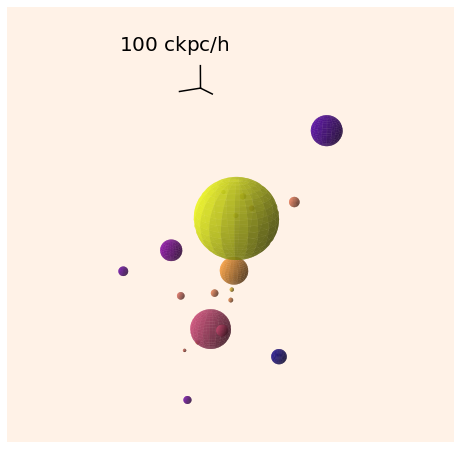

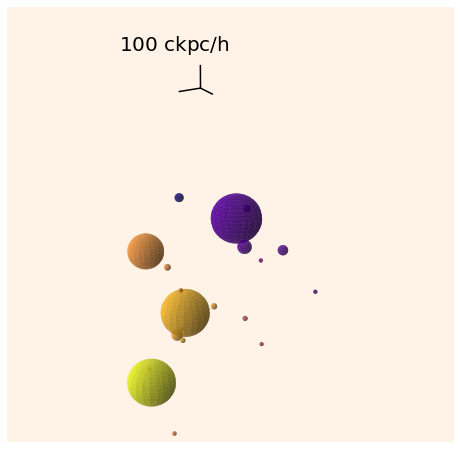

In [ ]:
idx = 9826

input_graph, input_cond  = preprocess_inputs(dataset,idx)

plot_pos_feat_3d(
    input_graph[0][:,:,:].numpy(), 
    input_graph[1][:,:,:].log().numpy(), 
    # fc=None, 
    azim=20, 
    elev=-30, 
    alpha=0.7, 
    width=500, 
    annotate=True, 
    grid_on=False, 
    scale_size=250,
    batch_idx = 0
    )



input_graph, input_cond  = dataset[idx]

cond_norm = torch.from_numpy(condition_normalizer.transform([input_cond[0].numpy()]))
# node_mask = input_graph[2].unsqueeze(0).repeat(2048,1,1)
nnodes = input_graph[2].sum().item()
node_mask = torch.ones(5,nnodes,1)
xpos, feat = sample_from_flows_with_context(prior, flow, node_mask, cond_norm)

nbins = 20


Msample_sorted, Msample_sorted_idx = torch.sort(
    feat[:,:,0], 
    dim=1, 
    descending=True)
x_sort_by_mass = torch.stack(
  [x[idx] for x, idx in zip(xpos, Msample_sorted_idx)]
)

feat_sorted_by_mass = torch.stack(
  [x[idx] for x, idx in zip(feat, Msample_sorted_idx)]
)



for i in range(5):
  plot_pos_feat_3d(
      x_sort_by_mass.cpu().detach().numpy()*300, 
      feat_sorted_by_mass.cpu().detach().numpy(), 
      fc=c1_rgba_01, 
      azim=20, 
      elev=-30, 
      alpha=0.7, 
      width=500, 
      annotate=True, 
      grid_on=False, 
      scale_size=250,
      batch_idx = i
      )

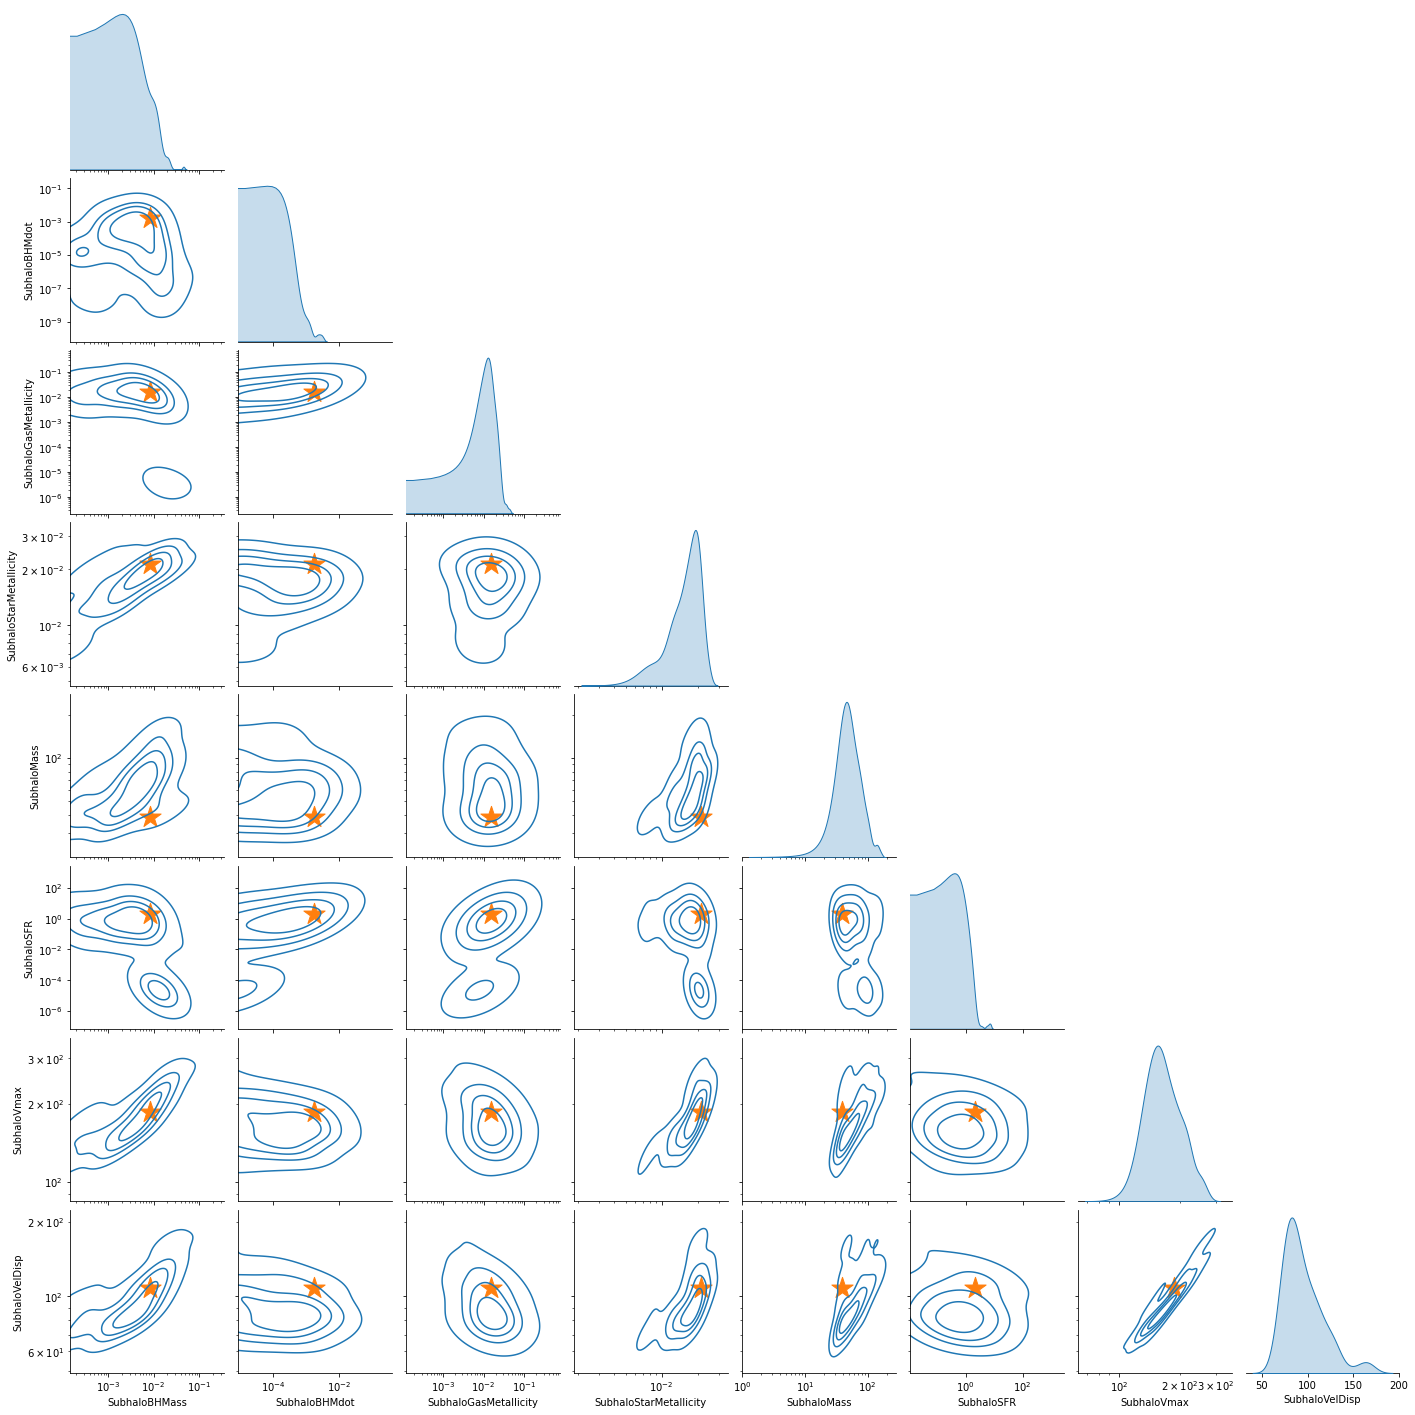

In [ ]:
g = sns.pairplot(
    dfcond_padded.sample(100), 
    # vars = ['SubhaloMass','SubhaloSFR'],
    kind='kde', 
    plot_kws={'log_scale':True, 'levels': 5},
    corner=True
    )
overlay_conditional(g, input_cond)

def overlay_conditional(g, input_cond, color='C1'):
  for i in range(8):
    for j in range(8):
      if i > j:
        g.axes[i][j].scatter(
            input_cond[0][j], 
            input_cond[0][i], 
            s=500, 
            marker='*', 
            color='C1'
            )
  return g

# Properties as a function of counts

In [ ]:
# sample the ones with >= 20 prog
mass_cols = [f"SubhaloMass_{m}" for m in range(20)] 
rows_with_20_prog = (dffeat[mass_cols] == 0).sum(axis=1) == 0

In [ ]:
dfcond_norm = condition_normalizer.transform(dfcond.values)

dfcond_norm[rows_with_20_prog]

array([[ 1.27806885, -0.03799566, -0.47217386, ...,  0.29818278,
         1.27317381,  1.52268455],
       [ 3.08263427, -1.13228592, -5.19933758, ..., -5.19933758,
         2.82034108,  2.04276407],
       [ 2.67115717, -5.19933758, -5.19933758, ..., -5.19933758,
         2.40862346,  2.22982909],
       ...,
       [-0.52689077,  0.55210452,  0.81465464, ..., -0.34313127,
        -1.66200583, -1.598113  ],
       [-0.50854952,  0.67781625,  1.8517538 , ..., -0.45903191,
        -1.09340449, -1.31334478],
       [-0.74268538, -0.23726893,  1.02839125, ..., -0.47123741,
        -2.71026989, -3.09693101]])

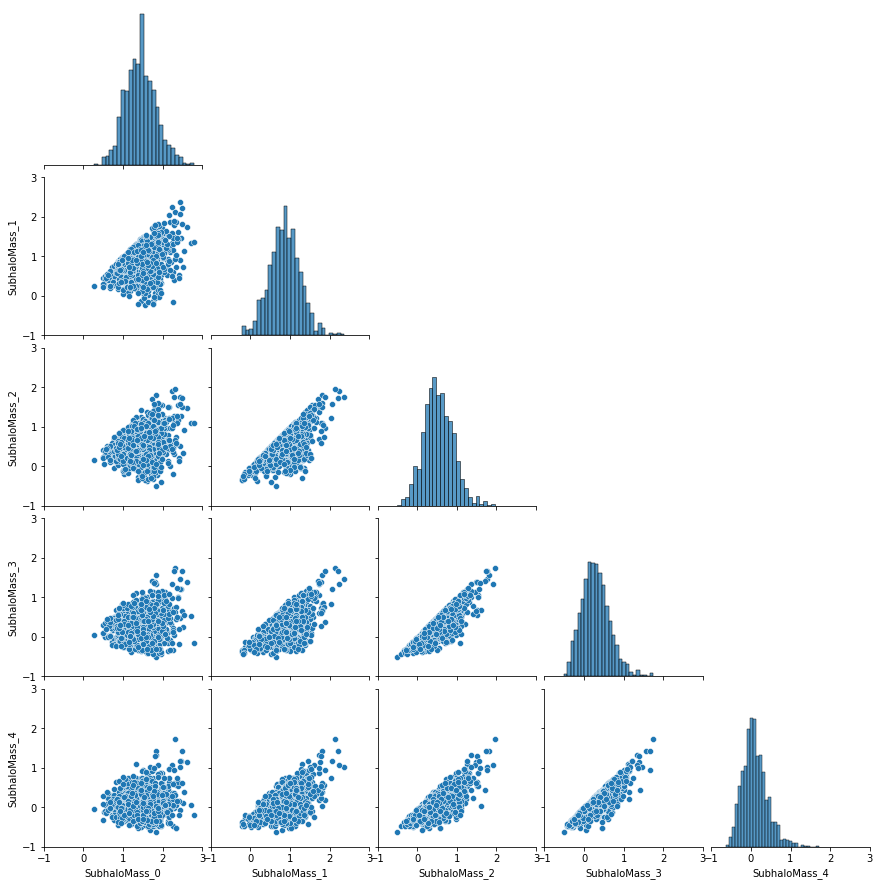

In [ ]:
axes = sns.pairplot(dffeat[rows_with_20_prog][mass_cols[:5]].apply(np.log10).sample(1000), corner=True, )
for f in axes.axes.flat:
  if f is None: continue
  f.set_xlim(-1,3)
  f.set_ylim(-1,3)  

In [ ]:
tmp_vals = feat_tweak1[:,:,0].sort( 1, True )[0][:,:5]

tmp_vals.shape

torch.Size([1024, 5])

In [ ]:
df_plot

SubhaloMass_0   SubhaloMass_1   SubhaloMass_2   SubhaloMass_3  \
0           1.406119        0.941386       -0.786959       -0.796702   
1           1.001826        0.863843        0.846106        0.736671   
2           1.406087        0.614732       -0.247871       -0.786959   
3           1.462882         0.23284       -0.013383       -0.137364   
4           0.937523        0.888228       -0.147108       -0.542446   
...              ...             ...             ...             ...   
3067  tensor(4.1501)  tensor(1.2711)  tensor(1.2560)  tensor(0.4491)   
3068  tensor(3.6008)  tensor(2.5142)  tensor(1.7483)  tensor(1.5232)   
3069  tensor(2.9691)  tensor(2.0173)  tensor(1.4716)  tensor(0.1808)   
3070  tensor(3.4322)  tensor(2.3239)  tensor(1.1877)  tensor(1.1783)   
3071  tensor(3.1109)  tensor(1.8145)  tensor(1.0816)  tensor(0.9101)   

       SubhaloMass_4 label  
0          -0.881229   all  
1           0.557046   all  
2          -0.814352   all  
3          -0.208109   all  
4          -0.778574   all  
...              ...   ...  
3067  tensor(0.1272)  cond  
3068  tensor(0.3949)  cond  
3069  tensor(0.0592)  cond  
3070  tensor(1.1292)  cond  
3071  tensor(0.8561)  cond  

[3072 rows x 6 columns]

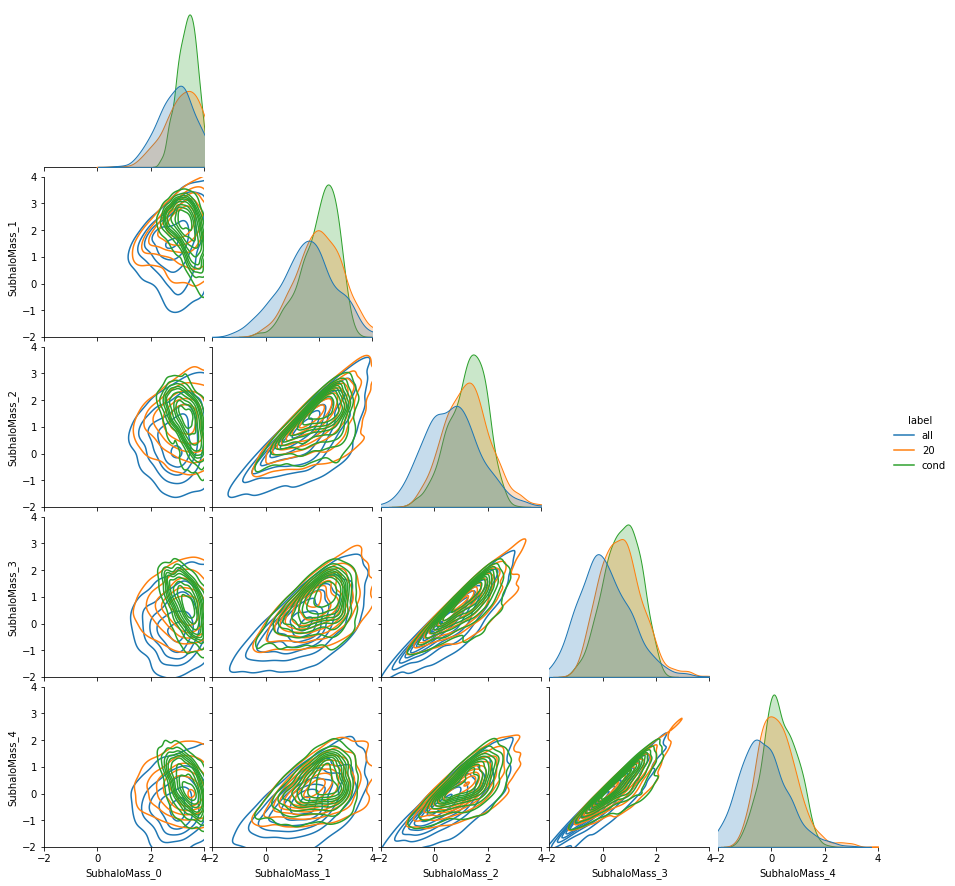

In [ ]:
_all_prog = dffeat[mass_cols[:5]].apply(np.log).sample(1024)
_20_prog  = dffeat[rows_with_20_prog][mass_cols[:5]].apply(np.log).sample(1024)



tmp = pd.DataFrame(tmp_vals.numpy(), columns=_all_prog.columns)


df_plot = pd.concat([_all_prog,_20_prog, tmp]).reset_index(drop=True)

df_plot['label'] = ["all"]*1024 + ["20"]*1024 + ["cond"] *1024



axes = sns.pairplot(df_plot, corner=True, hue='label', kind='kde')
for f in axes.axes.flat:
  if f is None: continue
  f.set_xlim(-2,4)
  f.set_ylim(-2,4)  

In [ ]:
def sample_from_flows_with_context_vectors(
    prior, 
    flow, 
    node_mask,
    context=torch.tensor([[0.]]), 
    context_transform= None,
    device='cpu'
    ):
  
  # prepare context
  n_samples, n_nodes, n_context = node_mask.shape
  # prepare a node mask, for now we assume its all visible
  node_mask = node_mask.to(device)

  if context_transform is not None:
    context = torch.from_numpy(context_transform(context)).unsqueeze(1)

  context_ = context.to(device)
  context_ = context_.unsqueeze(1).repeat(1,n_nodes,1) *node_mask
  assert_correctly_masked(context_, node_mask)

  edge_mask = (1 - torch.eye(n_nodes)).unsqueeze(0)
  edge_mask = edge_mask.repeat(n_samples, 1, 1).view(1, -1).to(device)

  # print(node_mask.shape, edge_mask.shape)
  # return node_mask, edge_mask
  with torch.no_grad():
    z_x, z_h = prior.sample(n_samples, n_nodes, node_mask)
    z = torch.cat([z_x, z_h], dim=2)
    tmp = flow.reverse(z, node_mask, edge_mask, context_.float())
    x    = tmp[:, :, 0:3].cpu()
    feat = tmp[:, :, 3:].cpu()
  return x, feat

In [ ]:
node_mask.shape

torch.Size([1024, 20, 1])

In [ ]:
nsamples = 10000
ntotal = 34057

n_nodes = 20

start_idx = list(range(0,ntotal,nsamples))

xpos_flow = []
feat_flow = []
for s in start_idx:
  # print(s, s+nsamples)
  end_idx = s + nsamples
  if end_idx > ntotal:
    end_idx = ntotal

  _node_mask = torch.ones(end_idx - s, n_nodes, 1)
  xpos, feat = sample_from_flows_with_context_vectors(
      prior, 
      flow, 
      _node_mask, 
      torch.from_numpy(dfcond_norm[rows_with_20_prog][s:end_idx])
      )
  
  xpos_flow.append(xpos)
  feat_flow.append(feat)

In [ ]:
xpos = torch.cat(xpos_flow)
feat = torch.cat(feat_flow)

In [ ]:
import torch
Msample_sorted, Msample_sorted_idx = torch.sort(
    feat[:,:,0], 
    dim=1, 
    descending=True)
x_sort_by_mass = torch.stack(
  [x[idx] for x, idx in zip(xpos, Msample_sorted_idx)]
)

feat_sorted_by_mass = torch.stack(
  [x[idx] for x, idx in zip(feat, Msample_sorted_idx)]
)

In [ ]:
from HaloEGNN.HaloEGNNFlows.EGNNFlows.viz.utils import order_halo_by_mass

In [ ]:
np.save("x_sort_by_mass.npy",x_sort_by_mass)
np.save("feat_sorted_by_mass.npy",feat_sorted_by_mass)

In [ ]:
metrics, _cols = compute_metric_features(
    x_sort_by_mass, 
    feat_sorted_by_mass, 
    max_prog=5, 
    column_names=['m','z']
)

In [ ]:
_metrics_df = pd.DataFrame(metrics,columns=_cols)

In [ ]:
_metrics_df.to_csv("metrics_df.csv")

In [ ]:
dffeat.to_csv("full_dffeat.csv")

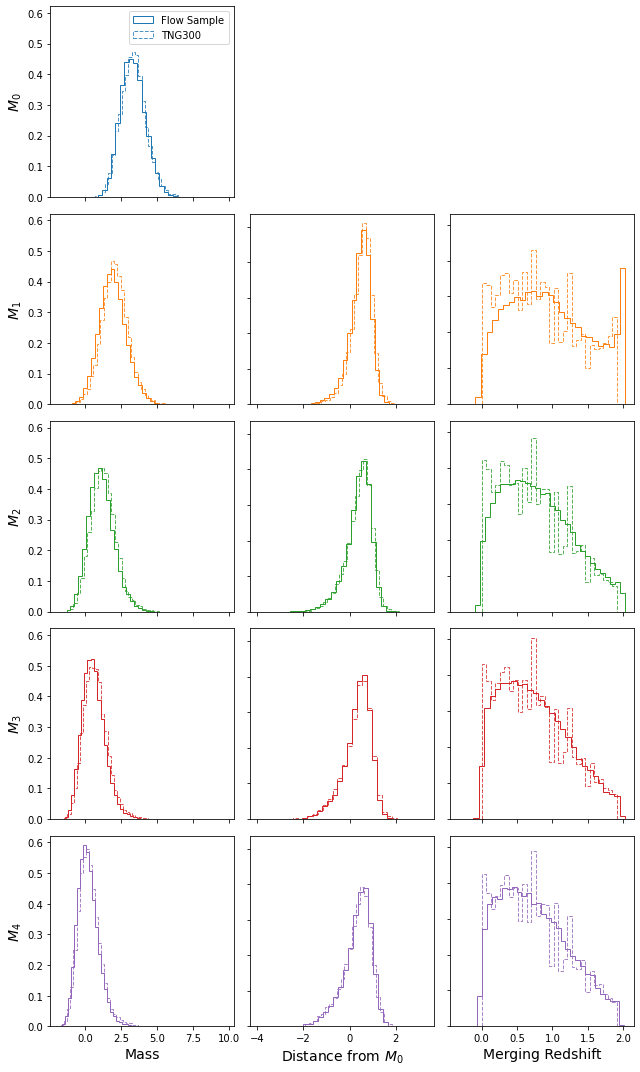

In [ ]:
f,axes = plt.subplots(
    5,3,
    sharey='col', 
    sharex='col', 
    figsize=(9,15),)
for i in range(1,5):
  _metrics_df[f'd0{i}'].apply(np.log10).plot.hist(
      bins=30, 
      density=True,
      histtype='step',
      ax=axes[i][1],
      color=f'C{i}'
      )
  dffeat[rows_with_20_prog][[f'd0{i}']].iloc[:len(_metrics_df)].apply(np.log10).plot.hist(
      ax=axes[i][1],alpha=0.8,bins=30, density=True,histtype='step', color=f'C{i}', ls='--')
  
  axes[i][1].get_legend().remove()


for i in range(5):
  _metrics_df[f'm_{i}'].plot.hist(
      bins=30, 
      density=True,
      histtype='step', 
      color=f'C{i}',
      ax=axes[i][0],
      label='Flow Sample'
      )
  dffeat[rows_with_20_prog][f'SubhaloMass_{i}'].iloc[:len(_metrics_df)].apply(np.log).plot.hist(
      ax=axes[i][0],
      alpha=0.8,
      bins=30, 
      density=True,
      histtype='step', 
      ls='--', 
      color=f'C{i}',
      label='TNG300'
      )
  
  if i == 0:
    axes[0][0].legend()
  # else:
  #   axes[i][0].get_legend().remove()
  # else:
    

for i in range(1,5):
  _metrics_df[f'z_{i}'].apply(lambda a: 1/a - 1).plot.hist(
      bins=30, 
      density=True,
      histtype='step', 
      color=f'C{i}',
      ax=axes[i][2])
  dffeat[rows_with_20_prog][[f'SubhaloMergeRedshift_{i}']].iloc[:len(_metrics_df)].plot.hist(
      ax=axes[i][2],
      alpha=0.8,
      bins=30, 
      density=True,
      histtype='step', 
      ls='--', 
      color=f'C{i}')
  axes[i][2].get_legend().remove()

for i in range(5):
  axes[i][0].set_ylabel(f"$M_{i}$", fontsize=14)


axes[-1][0].set_xlabel("Mass", fontsize=14)
axes[-1][1].set_xlabel(r"Distance from $M_0$", fontsize=14)
axes[-1][2].set_xlabel(r"Merging Redshift", fontsize=14)

axes[0][1].axis('off')
axes[0][2].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
f.savefig("MarginalDistribution.png")

# Conditional Dist

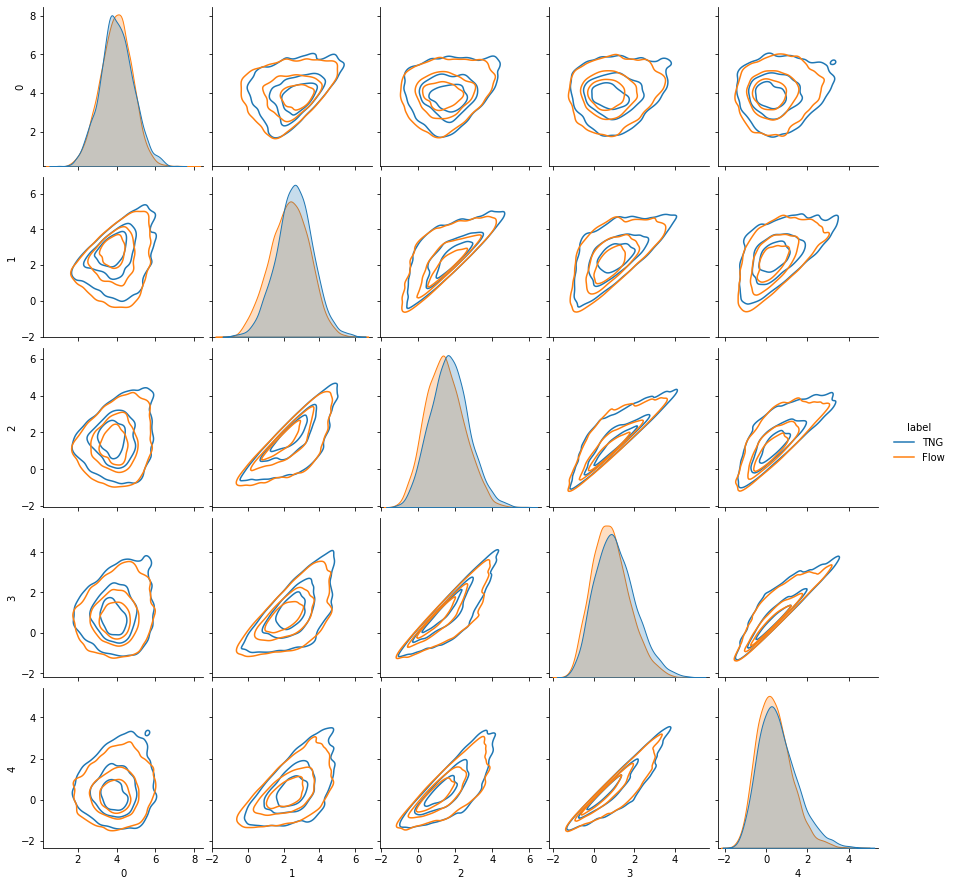

In [ ]:
feat_tng= np.log(dffeat[rows_with_20_prog][mass_cols[:5]].values)[:5000,:]

feat_samp = feat[:,:,0].sort(1,True)[0]

df1 = pd.DataFrame(feat_tng, columns=range(5))
df2 = pd.DataFrame(feat_samp.numpy()[:,:5], columns=range(5))

df_plot = pd.concat([df1,df2],).reset_index(drop=True)

df_plot['label'] = len(df1)*['TNG'] + len(df2)*['Flow']

sns.pairplot(df_plot, hue='label', kind='kde', plot_kws=dict(levels=4))

In [ ]:
all_feats = []
for r in dfcond_norm[rows_with_20_prog]:
  xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask[:1,:,:], torch.from_numpy(r[np.newaxis,:]) )
  all_feats.append(feat_tweak1)

In [ ]:
feat1 = torch.cat(all_feats)[:,:,0].sort(1, True)[0][:,:5]

v1 =  dffeat[rows_with_20_prog][mass_cols[:5]].apply(np.log).values[:len(feat1),:5]

In [ ]:
v1.shape, feat1.shape

((18784, 5), torch.Size([18784, 5]))

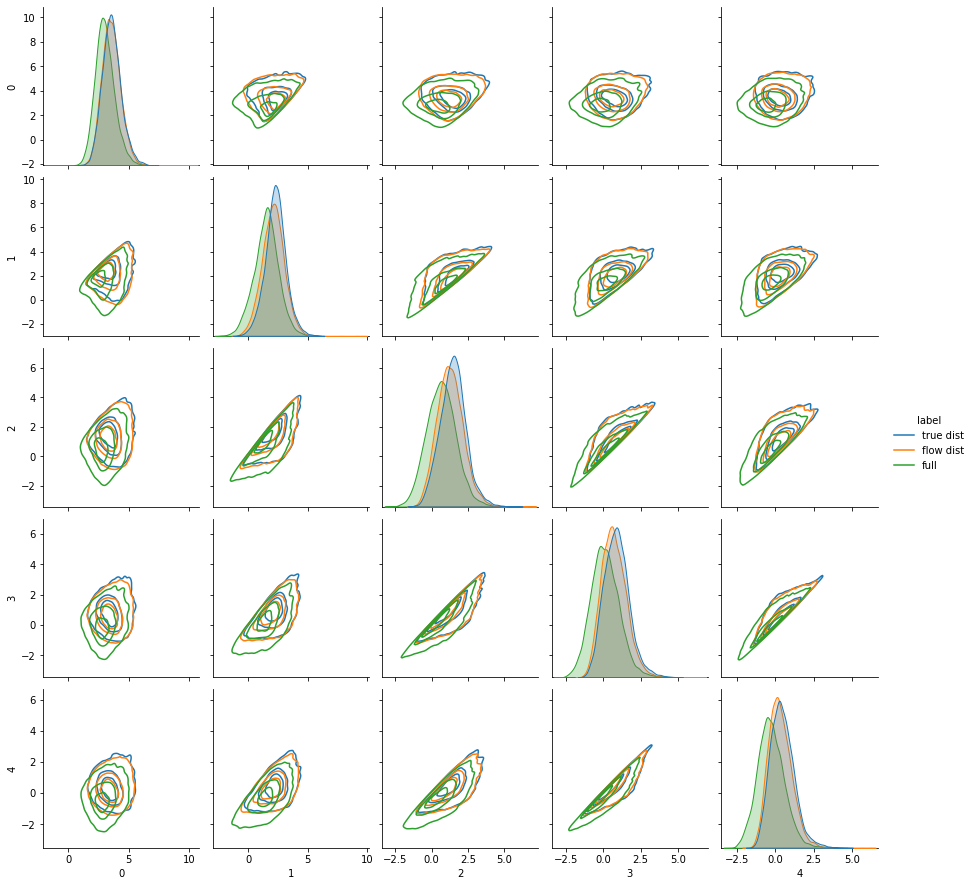

In [ ]:
data1 = pd.DataFrame(v1, columns=range(5))
data2 = pd.DataFrame(feat1[:,:5].numpy(), columns=range(5))

_all_prog = dffeat[mass_cols[:5]].apply(np.log).sample(len(data2))
_all_prog.columns = data2.columns

df_plot = pd.concat([data1, data2, _all_prog]).reset_index(drop=True)
df_plot['label'] = ['true dist']* len(data2) + ['flow dist']* len(data2)+ ['full']* len(data2)

sns.pairplot(df_plot, hue='label', kind='kde', plot_kws=dict(levels=4))

In [ ]:
input_graph, input_cond = preprocess_inputs(dataset,9826)

In [ ]:
# tweak  SubhaloVMax and generate a new graph
node_mask = input_graph[2] #.unsqueeze(0)

newcond = np.array([ 4, -0.7865858 , -1.84135233,  0.62049459,  0.10762174,
       -1.19464143,  2.5,  1.56575382])

context_tweak1 = torch.from_numpy(newcond).unsqueeze(0)


newcond = np.array([ 0.1, -0.7865858 , -1.84135233,  2.3,  0.10762174,
       -1.19464143,  0.8,  1.56575382])

context_tweak2 = torch.from_numpy(newcond).unsqueeze(0)

In [ ]:
condition_normalizer.inverse_transform(input_cond[0].numpy())

array([[8.43452010e-03, 1.69763283e-03, 1.53716197e-02, 2.11958662e-02,
        3.84593735e+01, 2.07924652e+00, 1.86527679e+02, 1.08006523e+02]])

In [ ]:
input_cond[0]

tensor([[ 0.5314,  1.9680,  0.2718,  0.9354, -1.2411,  1.1765,  0.2917,  0.7209]],
       dtype=torch.float64)

In [ ]:
xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak1)
xpos_tweak2, feat_tweak2 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)

torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])


In [ ]:
import matplotlib.pyplot as plt

from matplotlib.patches import Circle

def plot_graph(ax, x, feat, sample=True, facecolor='0.8', alpha=0.1):
  # f,ax = plt.subplots(figsize=(6,6))
  if sample:
    im = ax.scatter(x[0,:,0], x[0,:,1], s = feat[0,:,0].exp()*10, c = 1/feat[0,:,1]-1 )
    center = x[0,:,0].mean(), x[0,:,1].mean()
  else:
    X = x[:,0]/300
    Y = x[:,1]/300
    X = X - X.mean()
    Y = Y - Y.mean()
    im = ax.scatter(X, Y, s = feat[:,0]*10, c = feat[:,1])
    center = (0, 0)
    # print(center, x[:,0])

  circle = Circle(center, 5, facecolor=facecolor, alpha=alpha)
  ax.add_patch(circle)
  ax.set_aspect(1)

import matplotlib.pyplot as plt

import matplotlib
alpha=0.1

c0_rgba = matplotlib.colors.to_rgba_array("C0")[0]
c0_rgba_01 = c0_rgba*alpha + (1-alpha)* np.ones_like(c0_rgba)

c1_rgba = matplotlib.colors.to_rgba_array("C1")[0]
c1_rgba_01 = c1_rgba*alpha + (1-alpha)* np.ones_like(c1_rgba)

c2_rgba = matplotlib.colors.to_rgba_array("C2")[0]
c2_rgba_01 = c2_rgba*alpha + (1-alpha)* np.ones_like(c2_rgba)


c3_rgba = matplotlib.colors.to_rgba_array("C3")[0]
c3_rgba_01 = c3_rgba*alpha + (1-alpha)* np.ones_like(c3_rgba)

def plot_pos_feat_3d(x, feat, fc = c0_rgba_01, azim=-60, elev=30, scale_size=1, alpha=0.5, width = 2, annotate=False, grid_on=False, size_pow=1/1.5, return_fig=False, vmax=2, vmin=0.2, logcolor=True, ax=None):
  # norm = matplotlib.colors.Normalize(vmin=0.2, vmax=2)
  if logcolor:
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
  else:
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
  cmap = matplotlib.cm.get_cmap('plasma')

  assert x.ndim == 3
  assert feat.ndim == 3
  
  X = x[0,:,0].copy()
  Y = x[0,:,1].copy()
  Z = x[0,:,2].copy()

  midx = feat[0,:,0].argmax()
  # midx = 0
  X = X - X[midx]
  Y = Y - Y[midx]
  Z = Z - Z[midx]

  M = 0.1*(np.exp(feat[0,:,0]))**(size_pow) * scale_size

  z = 1/feat[0,:,1] - 1

  colors = cmap(norm(z))
  if ax is None:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

  ax.view_init(azim, elev)

  
  ax.set_xlim(-width, width)
  ax.set_ylim(-width, width)
  ax.set_zlim(-width, width)

  if fc is not None:
    ax.set_facecolor(fc)
  #ax.xaxis.pane.set_edgecolor('#D0D0D0')
  ax.xaxis.pane.set_alpha(0)
  ax.yaxis.pane.set_alpha(0)
  ax.zaxis.pane.set_alpha(0)
  

  # Hide grid lines
  if not grid_on:
    ax.grid(False)
    ax._axis3don = False

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

  if annotate:
    anchor = np.array([-300,0,500])
    dx = np.array([1, 0, 0])
    dy = np.array([0, 1, 0]) 
    dz = np.array([0, 0, 1])

    dx = 100
    ax.plot(xs=[anchor[0], anchor[0]+ dx], ys = [anchor[1], anchor[1]], zs=[anchor[2], anchor[2]], color='k')
    ax.plot(xs=[anchor[0], anchor[0]], ys = [anchor[1], anchor[1]- dx], zs=[anchor[2], anchor[2]], color='k')
    ax.plot(xs=[anchor[0], anchor[0]], ys = [anchor[1], anchor[1]], zs=[anchor[2], anchor[2]+ dx], color='k')

    ax.text2D(0.25, 0.9, r"$\mathrm{100 ~  ckpc/h} $", transform=ax.transAxes, fontsize=20)

  # ax.plot(xs=[anchor[1], anchor[1]+ dx], ys = [anchor[2], anchor[2]], zs=anchor[0], zdir='y',color='k')
  # ax.plot(xs=[anchor[2], anchor[2]+ dx], ys = [anchor[0], anchor[0]], zs=anchor[1], zdir='x',color='k')

  # ax.plot(xs=[-6*100,-5*100], ys = [-6*100,-6*100], zs=-6*100, zdir='z',color='k')
  # ax.plot(ys=[-6*100,-5*100], xs = [-6*100,-6*100], zs=-6*100, zdir='y',color='k')
  # ax.plot(ys=[-6*100,-7*100], xs = [-6*100,-6*100], zs=-6*100, zdir='k',color='k')

  plots = []

  max_counts = 20
  counts = 0
  for i, j, k, s, c in zip(X, Y, Z, M, colors):
    # print(i,j,k,s,c)
    plots.append(draw_sphere(ax, i.item(), j.item(), k.item(), s.item(), c, rstride=5, cstride=5, alpha=alpha))

    counts += 1
    if counts > max_counts: break
  # fig.colorbar(plots[-1])
  return ax
  if not return_fig:
    plt.show()
    plt.close(fig)
  else:
    return fig

def draw_sphere(ax, x, y, z, size, color, rstride=2, cstride=2, alpha=0.3):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v))
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    # for i in range(2):
    #    ax.plot_surface(x+random.randint(-5,5), y+random.randint(-5,5), z+random.randint(-5,5),  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)

    return ax.plot_surface(x + xs, y + ys, z + zs, rstride=rstride, cstride=rstride, color=color, linewidth=0,
                    alpha=alpha, vmin=0.0, vmax=2.0)

In [ ]:
truth_cond = input_cond[0].numpy()

In [ ]:
truth_cond.shape

(1, 8)

In [ ]:
cond1, cond2, cond3 = condition_normalizer.transform(dfcond_padded.sample(3).values)

truth_cond = cond1[np.newaxis,:]
context_tweak1 = torch.from_numpy(cond2).unsqueeze(0)
context_tweak2 = torch.from_numpy(cond3).unsqueeze(0)

torch.Size([1, 20, 1]) torch.Size([1, 400])
tensor([0.7022, 1.9128, 2.0035, 0.0707, 0.4889, 0.4418, 0.6301, 1.8361, 0.9938,
        0.6802, 0.9688, 1.2540, 1.6547, 0.1333, 0.4415, 0.7022, 1.6193, 1.1471,
        0.2493, 0.4418]) tensor(2)
tensor([-1.8587, -2.1913,  2.8623, -0.6908, -2.2615, -2.3964,  0.3113, -0.0347,
        -1.7452, -1.9344,  2.1497, -1.3788, -0.2919, -0.6402, -2.3729, -1.9080,
        -1.7693, -2.0535, -0.7894, -0.3487]) tensor(2)
torch.Size([1, 20, 1]) torch.Size([1, 400])
tensor([0.6346, 0.6811, 1.1031, 1.2514, 0.9954, 0.0909, 1.7316, 0.9953, 0.9953,
        0.3538, 0.9952, 0.9581, 0.8850, 1.4938, 1.2273, 1.7340, 0.0652, 1.7343,
        2.0116, 0.9343]) tensor(18)
tensor([-0.6449, -1.9173, -1.7145, -1.9117, -0.7320, -0.6205,  1.9680, -0.5390,
        -1.7211, -1.1215, -1.2484, -0.6637, -1.9470, -1.6842, -1.8928, -1.1547,
         0.6522,  0.7707,  2.4627, -1.3962]) tensor(18)
torch.Size([1, 20, 1]) torch.Size([1, 400])
tensor([0.1947, 1.0461, 0.9855, 1.3714, 0.1948

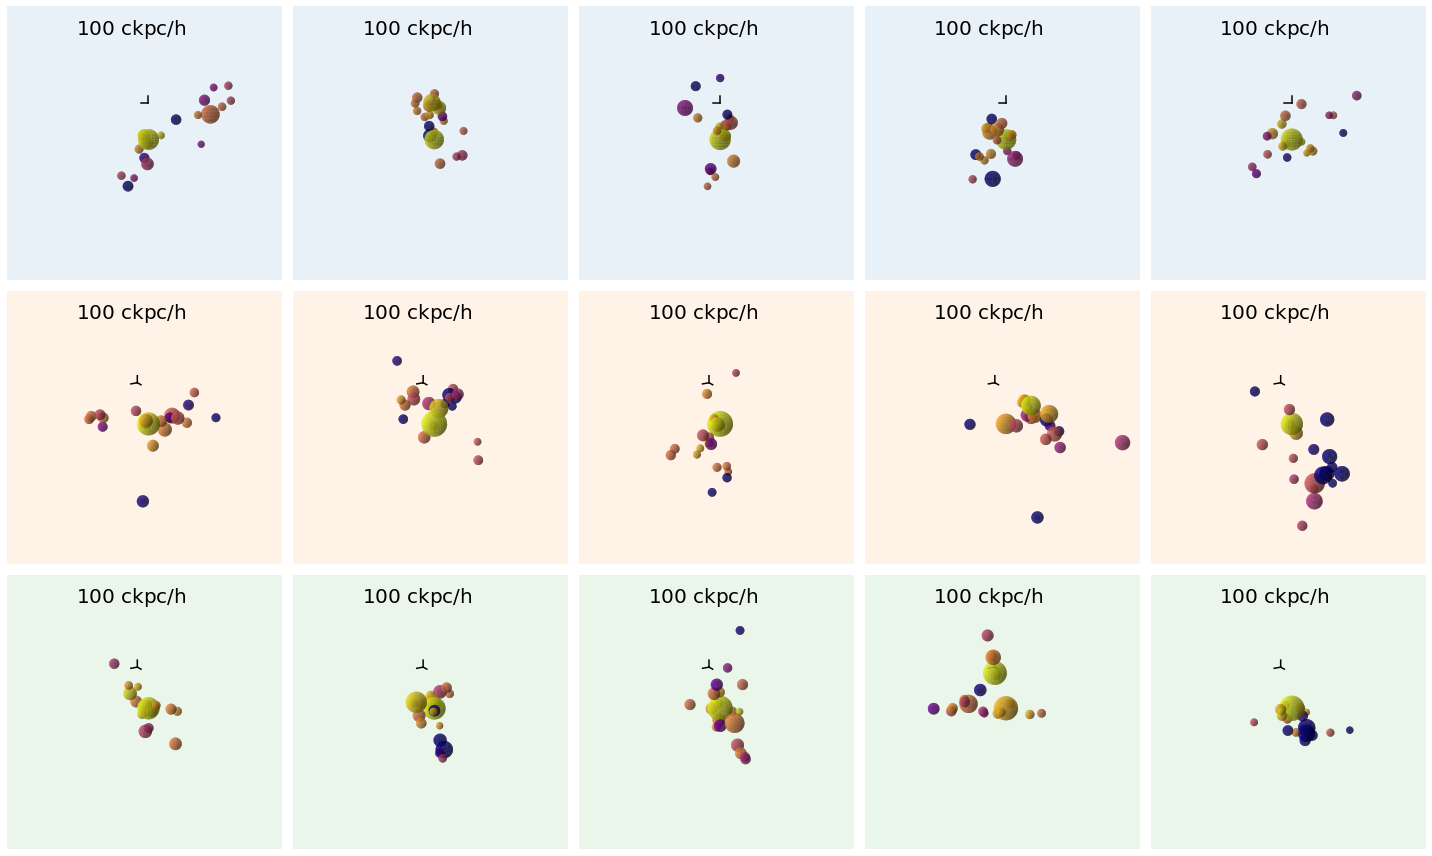

In [ ]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(20,12) )

# =============
# First subplot
# =============
# set up the axes for the first plot

context_truth = torch.from_numpy(truth_cond)

# 1st row plot
zidx = 1
midx = 2
for i in range(5):
  ax = fig.add_subplot(3, 5,  i+1, projection='3d')

  zidx = 1
  midx = 2
  while zidx != midx:
    xpos, feat = sample_from_flows_with_context(prior, flow, node_mask, context_tweak1)
    zidx = (1/feat[0,:,1] - 1).argmax()
    midx = feat[0,:,0].argmax()

  print(1/feat[0,:,1] - 1, zidx)
  print(feat[0,:,0], midx)

  plot_pos_feat_3d(xpos.numpy()*300, feat.numpy(), fc= c0_rgba_01 , azim=0, elev=0, alpha=0.7, width=1000, annotate=True, grid_on=False, scale_size=800, ax=ax, size_pow=0.2,)




# 2nd row plot
for i in range(5):
  ax = fig.add_subplot(3, 5,  i+5+1, projection='3d')
  xpos, feat = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)
  plot_pos_feat_3d(xpos.numpy()*300, feat.numpy(), fc=c1_rgba_01, azim=20, elev=-30, alpha=0.7, width=1000, annotate=True, grid_on=False, scale_size=800, ax=ax, size_pow=0.2)

# 3rd row plot
for i in range(5):
  ax = fig.add_subplot(3, 5,  i+10+1, projection='3d')
  xpos, feat = sample_from_flows_with_context(prior, flow, node_mask, context_truth)

  zidx = (1/feat[:,1] - 1).argmax()
  midx = feat[:,0].argmax()
  print(zidx,midx)

  plot_pos_feat_3d(xpos.numpy()*300, feat.numpy(), fc=c2_rgba_01, azim=20, elev=-30, alpha=0.7, width=1000, annotate=True, grid_on=False, scale_size=800, ax=ax, size_pow=0.2)


plt.tight_layout()


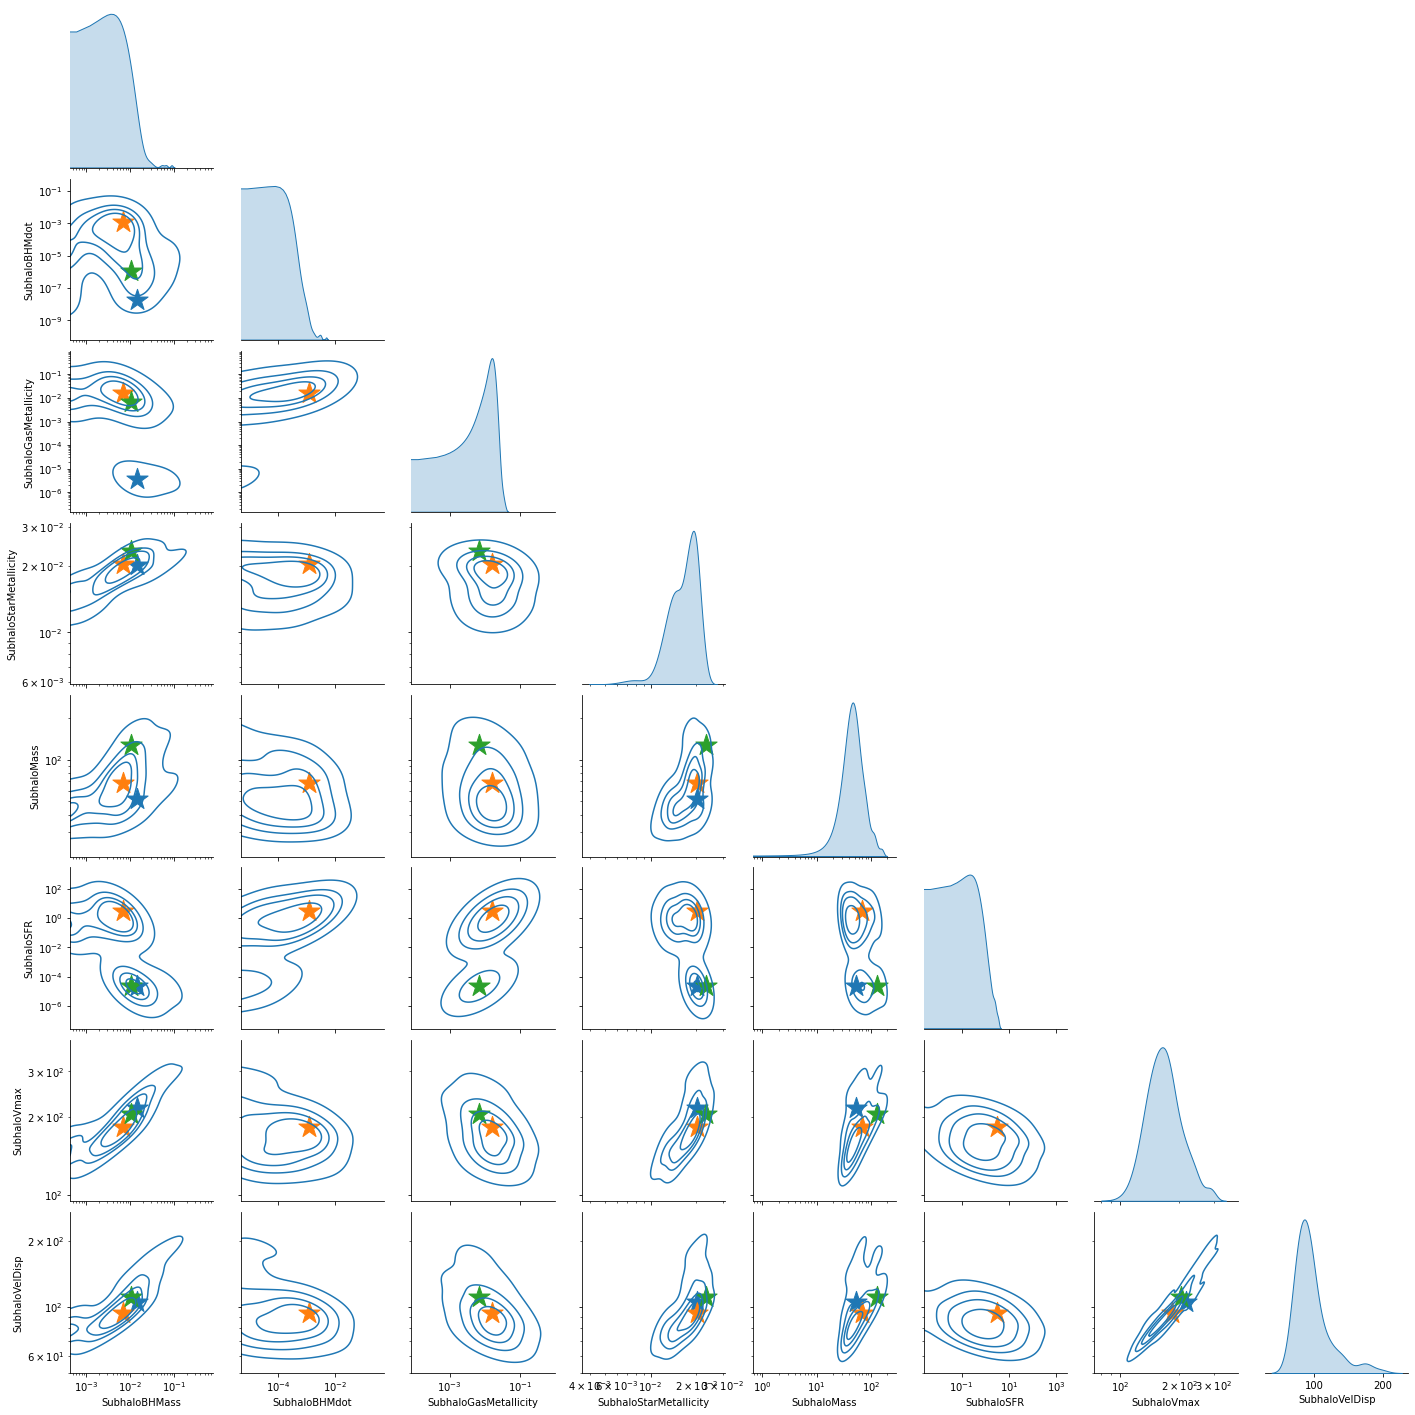

In [ ]:
g = sns.pairplot(
    dfcond_padded.sample(100), 
    # vars = ['SubhaloMass','SubhaloSFR'],
    kind='kde', 
    plot_kws={'log_scale':True, 'levels': 5},
    corner=True
    )
overlay_conditional(g, condition_normalizer.inverse_transform(truth_cond),color='C0')
overlay_conditional(g, condition_normalizer.inverse_transform(context_tweak1), color='C1')
overlay_conditional(g, condition_normalizer.inverse_transform(context_tweak2), color='C2')

NameError: ignored

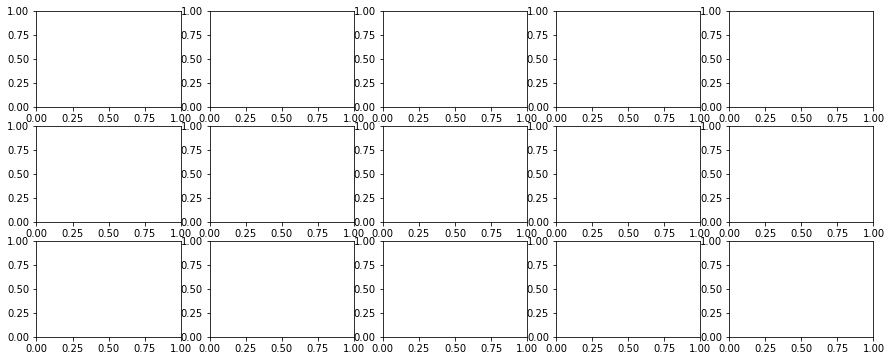

In [ ]:
nrows = 3
ncols = 5
f,axes = plt.subplots(nrows,ncols, figsize=(15,6))

colors = [c0_rgba_01, c2_rgba_01, c3_rgba_01]

context_truth = torch.from_numpy(truth_cond)
for i, context in enumerate([context_tweak1, context_truth, context_tweak2]):
  for j in range(ncols):
    xpos, feat = sample_from_flows_with_context(prior, flow, node_mask, context)

    plot_pos_feat_3d(xpos.numpy()*300, feat.numpy(), fc=colors[i], azim=20, elev=-30, alpha=0.7, width=500, annotate=True, grid_on=False, scale_size=50)
    break

# plot_pos_feat_3d(xpos_tweak1.numpy()*300, feat_tweak1.numpy(), fc=c1_rgba_01, azim=20, elev=-30, alpha=0.7, width=500, annotate=True, grid_on=False, scale_size=250)
# plot_pos_feat_3d(x_tweak1*300, feat_tweak1, fc=c0_rgba_01, azim=20, elev=-30, alpha=0.7, width=500, annotate=False, grid_on=False, scale_size=250)
# plot_pos_feat_3d(x_tweak2*300, feat_tweak2, fc=c3_rgba_01, azim=20, elev=-30, alpha=0.7, width=500, annotate=False, grid_on=False, scale_size=250)

torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])
torch.Size([1, 20, 1]) torch.Size([1, 400])


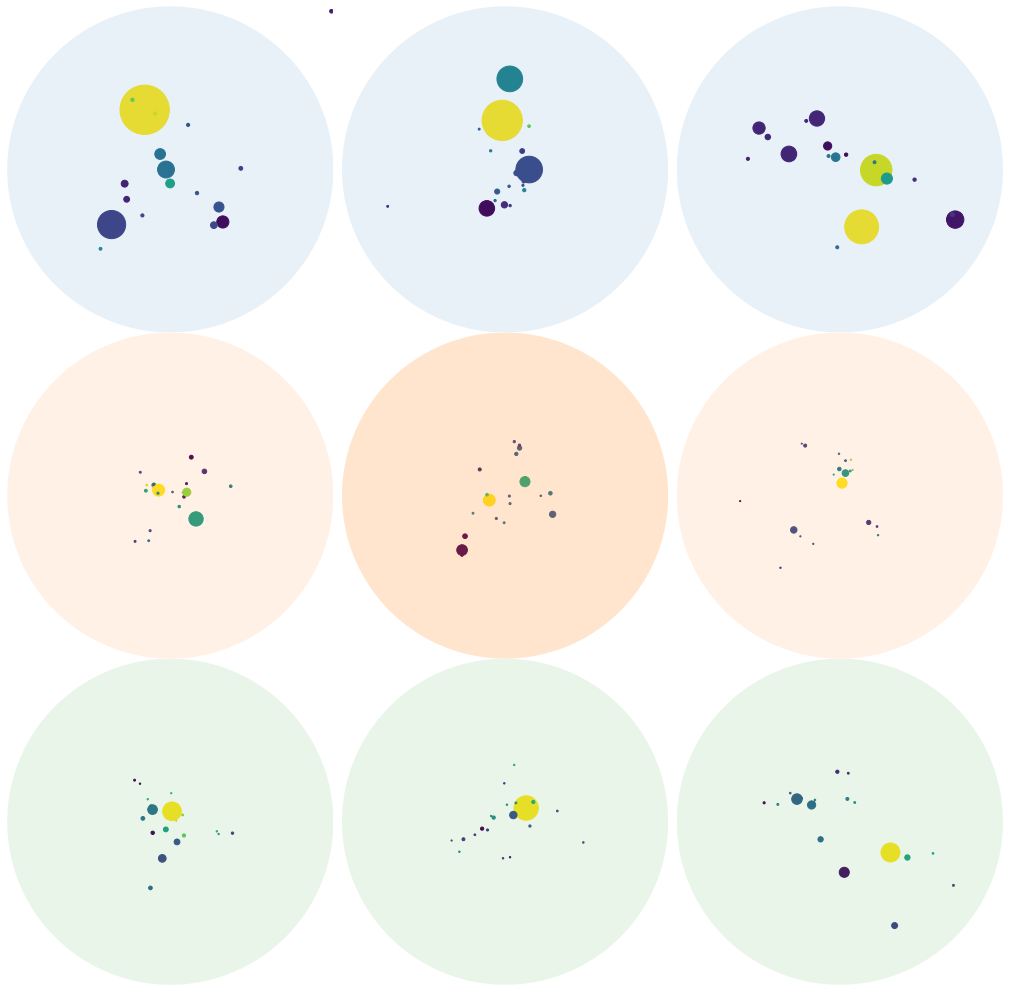

In [ ]:
f,axes = plt.subplots(3,3, figsize=(18,18))
axes = axes.flat
xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak1)
plot_graph(axes[0],xpos_tweak1, feat_tweak1, sample=True, facecolor='C0')

xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak1)
plot_graph(axes[1],xpos_tweak1, feat_tweak1, sample=True, facecolor='C0')

xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak1)
plot_graph(axes[2],xpos_tweak1, feat_tweak1, sample=True, facecolor='C0')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')


xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, torch.from_numpy(truth_cond))
plot_graph(axes[3],xpos_tweak1, feat_tweak1, sample=True, facecolor='C1')

xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, torch.from_numpy(truth_cond))
plot_graph(axes[5],xpos_tweak1, feat_tweak1, sample=True, facecolor='C1')

plot_graph(axes[4], input_graph[0], input_graph[1], sample=False, alpha=0.2, facecolor='C1')
axes[4].axis('off')

xpos_tweak2, feat_tweak2 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)
plot_graph(axes[6],xpos_tweak2, feat_tweak2, sample=True, facecolor='C2')

xpos_tweak2, feat_tweak2 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)
plot_graph(axes[7],xpos_tweak2, feat_tweak2, sample=True, facecolor='C2')

xpos_tweak2, feat_tweak2 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)
plot_graph(axes[8],xpos_tweak2, feat_tweak2, sample=True, facecolor='C2')

for i in range(9):
  axes[i].axis("off")
  axes[i].set_aspect(1)
  axes[i].set_xlim(-5,5)
  axes[i].set_ylim(-5,5)
plt.subplots_adjust(wspace=0,hspace=0)
# xpos_tweak2, feat_tweak2 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)

# plot_graph(axes[0],xpos_tweak1, feat_tweak1, sample=True, facecolor='C0')
# plot_graph(xpos_tweak2, feat_tweak2, sample=True, facecolor='C2')

In [ ]:
# plot_graph(input_graph[0], input_graph[1], sample=False, alpha=0.1, facecolor='C1')

In [ ]:
labels

['BHMass',
 'BHMdot',
 'GasMetallicity',
 'StarMetallicity',
 'Mass',
 'SFR',
 'Vmax',
 'VelDisp']

In [ ]:
for i, l in enumerate(labels_to_keep):
  if l in labels:
    print(i,l, labels)

NameError: ignored

In [ ]:
len(dataset)

76105

In [ ]:
input_graph, input_cond = preprocess_inputs(dataset,idx)
input_cond

[tensor([[ 0.5314,  1.9680,  0.2718,  0.9354, -1.2411,  1.1765,  0.2917,  0.7209]],
        dtype=torch.float64)]

In [ ]:
input_cond[0]

tensor([[ 0.5314,  1.9680,  0.2718,  0.9354, -1.2411,  1.1765,  0.2917,  0.7209]],
       dtype=torch.float64)

In [ ]:
# newcond = np.array([ 4, -0.7865858 , -1.84135233,  0.62049459,  0.10762174,
#        -1.19464143,  2.5,  1.56575382])

# input_graph, input_cond = preprocess_inputs(dataset,31)

context_tweak1 = input_cond[0].clone()
context_tweak2 = input_cond[0].clone()
# +- 2 for BHMass, idx = 0
context_tweak1[:,0] += 0.8
context_tweak2[:,0] -= 1.0

# +- 2 for GasMetallicity, idx = 2
context_tweak1[:,3] += 0.6
context_tweak2[:,3] -= 2.0

# +- 2 for VelDisp, idx = 7
context_tweak1[:,7] += 0.8
context_tweak2[:,7] -= 0.9


# context_tweak1 = torch.from_numpy(newcond).unsqueeze(0)


# newcond = np.array([ 0.1, -0.7865858 , -1.84135233,  2.3,  0.10762174,
#        -1.19464143,  0.8,  1.56575382])

# context_tweak2 = torch.from_numpy(newcond).unsqueeze(0)

In [ ]:
dfmcmc = pd.DataFrame(flat_samples, columns=labels)
try:
  dfcond_norm.columns = labels
except:
  pass
def draw2dcontour(ax, xvars, yvars, cmap1="ch:s=.25,rot=-.25", cmap2="C1"):
  sns.kdeplot(
      data=dfcond_norm, 
      x = xvars,
      y = yvars,
      alpha=0.5, 
      # fill=True, 
      # color='mako',
      # palette='mako',
      levels=5,
      cmap=cmap1,
      gridsize=64,
      ax=ax
      )

  sns.kdeplot(
    data=dfmcmc, 
    x = xvars,
    y = yvars,
    # alpha=0.3, 
    # fill=True, 
    # color='mako',
    # palette='mako',
    # color='k',
    color=cmap2,
    levels=[0.2,0.5, 0.8],
    # cmap='',
    gridsize=64,
    ax=ax
    )
  ax.set_xlim(-4, 4)
  ax.set_ylim(-4, 4)
  ax.set_aspect(1.)
  return ax

NameError: ignored

In [ ]:
labels

NameError: ignored

In [ ]:
flat_samples = backend.get_chain(discard=1000, flat=True)
print(flat_samples.shape)

labels = [condition_columns[i][7:] for i in range(8)] #+ [context_tweak1] + [context_tweak2]


labels_to_keep = labels #['BHMass', "StarMetallicity", "VelDisp"]
labels_to_keep_names = ['BH Mass','BH Accretion Rate','Gas Metallicity','Star Metallicity', "Mass", "Star Formation Rate", "VMax", "Velocity Dispersion"]
index_to_keep = [i for i, l in enumerate(labels) if l in labels_to_keep]
print(index_to_keep)

nrows = len(index_to_keep)
truths_keep =input_cond[0][0, index_to_keep]
flat_samples_keep = flat_samples[:, index_to_keep]

fig = corner.corner(
    flat_samples_keep, labels=labels_to_keep, truths=truths_keep, truth_color='C1'
);

axes = fig.axes

for i, ii in enumerate(index_to_keep):
  for j, jj in enumerate(index_to_keep):
    if j > i:
      continue
    elif j == i:
      # axes[i*nrows+j].axvline(context_tweak1[0][jj], color='C0')
      # axes[i*nrows+j].axvline(context_tweak2[0][jj], color='C3')

      # sns.kdeplot(data=dfcond_norm,x=labels_to_keep[j], ax=axes[i*nrows+j], )
      # axes[i*nrows+j].hist(dfcond_norm[labels_to_keep[j]].values, histtype='step', bins=30, weights=np.ones(len(dfcond_norm))/ len(dfcond_norm)* len(dfmcmc) )
      axes[i*nrows+j].set_xlim(-3,3)
    else:
      # axes[i*nrows+j].scatter([context_tweak1[0][jj]], [context_tweak1[0][ii]], color='C0', s=500, marker='*')
      # axes[i*nrows+j].scatter([context_tweak2[0][jj]], [context_tweak2[0][ii]], color='C3', s=500, marker='*')


      # axes[i*nrows+j].scatter([context_tweak1[0][jj]], [context_tweak1[0][ii]], color='C0', s=500, marker='*')
      sns.kdeplot(data=dfcond_norm,x=labels_to_keep[j], y=labels_to_keep[i], ax=axes[i*nrows+j], gridsize=32, levels=5, fill=True, alpha=0.2,color='C2')
      axes[i*nrows+j].set_xlim(-3,3)
      axes[i*nrows+j].set_ylim(-3,3)
      
      if i != 0:
        axes[i*nrows+j].set_yticklabels([])
    
    if j == 0 and i > 0:
      axes[i*nrows+j].set_ylabel(labels_to_keep_names[i],fontsize=16)
    if i == 7:
      axes[i*nrows+j].set_xlabel(labels_to_keep_names[j],fontsize=16)
    if j > 0:
      axes[i*nrows+j].set_ylabel("")
  
fig.savefig("mcmc.png", dpi=300)

NameError: ignored

In [ ]:
# corner.corner??

np.arange(0.5, 2.1, 0.5) 

array([0.5, 1. , 1.5, 2. ])

In [ ]:
levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

levels

array([0.1175031 , 0.39346934, 0.67534753, 0.86466472])

In [ ]:
# contour background prior filled low alpha


In [ ]:
# dfmcmc['label'] = 'Posterior'
# dfcond_norm['label'] = 'Prior'

# dfall = pd.concat([dfmcmc, dfcond_norm],axis=0).reset_index(drop=True)

# sns.pairplot(
#     data=dfall,
#     x_vars=labels_to_keep,
#     y_vars=labels_to_keep,
#     hue='label',
#     kind='kde',
#     plot_kws={"gridsize":64, "levels":[0.2,0.5,0.8], "common_norm": False}
# )

In [ ]:
# labels_to_keep = ['BHMass', "StarMetallicity", "GasMetallicity", "VelDisp"]

# f, axes = plt.subplots(
#     len(labels_to_keep),
#     len(labels_to_keep), 
#     figsize=(9,9),
#     )


# for i, l1 in enumerate(labels_to_keep):
#   for j, l2 in enumerate(labels_to_keep):
#     if j > i:
#       axes[i,j].set_axis_off()
#     elif j == i:
#       sns.kdeplot(x=l1, data=dfcond_norm,ax=axes[i,j])
#       sns.kdeplot(x=l2, data=dfmcmc,ax=axes[i,j])
#       axes[i,j].set_xticks([])
#       axes[i,j].set_yticks([])

#       axes[i,j].yaxis.set_ticklabels([])
#       axes[i,j].xaxis.set_ticklabels([])
#       # axes[i,j].set_
#     else:
#       draw2dcontour(axes[i,j],l2,l1)

# plt.tight_layout()

In [ ]:
flow.transformations[1].odefunc.method = 'exact'
# input_graph, input_cond = preprocess_inputs(dataset,31)
input_graph, input_cond = preprocess_inputs(dataset,9826)
nll, loss, z_x, z_h = flow_forward(flow, prior, input_graph, input_cond, device=device, ode_regularization=0.01)

print(nll, loss)

tensor(9.7741, grad_fn=<NegBackward0>) tensor(22.9437, grad_fn=<AddBackward0>)


In [ ]:
import matplotlib
alpha=0.1

c0_rgba = matplotlib.colors.to_rgba_array("C0")[0]
c0_rgba_01 = c0_rgba*alpha + (1-alpha)* np.ones_like(c0_rgba)

c1_rgba = matplotlib.colors.to_rgba_array("C1")[0]
c1_rgba_01 = c1_rgba*alpha + (1-alpha)* np.ones_like(c1_rgba)

c3_rgba = matplotlib.colors.to_rgba_array("C3")[0]
c3_rgba_01 = c3_rgba*alpha + (1-alpha)* np.ones_like(c3_rgba)

In [ ]:
z = torch.cat([z_x, z_h], dim=2).float().detach()
tmp = flow.reverse(z, input_graph[2], input_graph[3].long(), context_tweak2.repeat(20,1).float() )
x_tweak2    = tmp[:, :, 0:3].cpu().detach().numpy()
feat_tweak2 = tmp[:, :, 3:].cpu().detach().numpy()


z = torch.cat([z_x, z_h], dim=2).float().detach()
tmp = flow.reverse(z, input_graph[2], input_graph[3].long(), context_tweak1.repeat(20,1).float() )
x_tweak1    = tmp[:, :, 0:3].cpu().detach().numpy()
feat_tweak1 = tmp[:, :, 3:].cpu().detach().numpy()

z = torch.cat([z_x, z_h], dim=2).float().detach()
tmp = flow.reverse(z, input_graph[2], input_graph[3].long(), input_cond[0].repeat(20,1).float() )
x_original    = tmp[:, :, 0:3].cpu().detach().numpy()
feat_original = tmp[:, :, 3:].cpu().detach().numpy()


NameError: ignored

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(1/ feat_original[0,:,1] - 1)
# plt.hist(1/ feat_tweak1[0,:,1] - 1)
# plt.hist(1/ feat_tweak1[0,:,1] - 1)

In [ ]:
zorg = feat_original[0,:,1]
z1 = feat_tweak1[0,:,1]

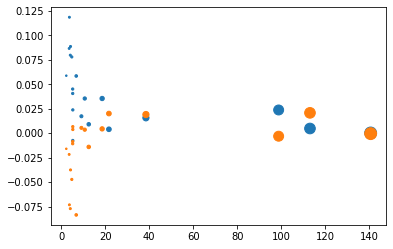

In [ ]:
plt.scatter(10*np.exp(feat_original[0,:,0]), 1/ feat_original[0,:,1] - 1/ feat_tweak1[0,:,1], s = 10*np.exp(feat_original[0,:,0]))
plt.scatter(10*np.exp(feat_original[0,:,0]), 1/ feat_original[0,:,1] - 1/ feat_tweak2[0,:,1], s = 10*np.exp(feat_original[0,:,0]))
# plt.scatter(1/ feat_original[0,:,1] - 1, 1/ feat_tweak2[0,:,1] - 1/feat_original[0,:,1])

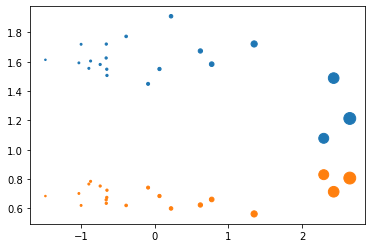

In [ ]:
plt.scatter(feat_original[0,:,0], np.exp(feat_tweak1[0,:,0]-feat_original[0,:,0]), s = 10*np.exp(feat_original[0,:,0]))
plt.scatter(feat_original[0,:,0], np.exp(feat_tweak2[0,:,0]-feat_original[0,:,0]), s = 10*np.exp(feat_original[0,:,0]))

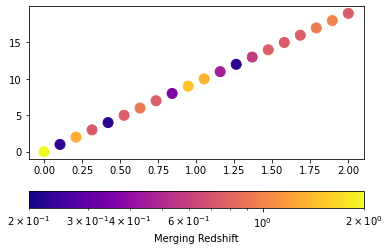

In [ ]:
import matplotlib
norm = matplotlib.colors.LogNorm(vmin=0.2, vmax=2)
# norm = matplotlib.colors.Normalize(vmin=0.2, vmax=2)
cmap = matplotlib.cm.get_cmap('plasma')

plt.scatter( np.linspace(0,2,20), np.arange(20), c = 1/feat_original[0,:,1]-1, cmap=cmap, norm = norm, s = 100)
plt.colorbar(orientation='horizontal',label='Merging Redshift')

In [ ]:
1/feat_original[0,:,1]-1

array([2.0020604 , 0.22765064, 1.2905469 , 0.7383441 , 0.22618186,
       0.7565702 , 0.9234234 , 0.7566327 , 0.3604641 , 1.4976525 ,
       1.3387425 , 0.46063673, 0.22636032, 0.576473  , 0.75672615,
       0.7374157 , 0.75669193, 0.9526514 , 1.0020382 , 0.73750913],
      dtype=float32)

In [ ]:
a = matplotlib.cm.get_cmap('tab10')

x = np.linspace(0,1,6)

In [ ]:
x = x_original
X = x[0,:,0].copy()
Y = x[0,:,1].copy()
Z = x[0,:,2].copy()

In [ ]:
feat_original[0,:,0].argmax()

0

In [ ]:
import matplotlib.pyplot as plt
def plot_pos_feat_3d(x, feat, fc = c0_rgba_01, azim=-60, elev=30, scale_size=1, alpha=0.5, width = 2, annotate=False, grid_on=False, size_pow=1/1.5, return_fig=False, vmax=2, vmin=0.2, logcolor=True):
  # norm = matplotlib.colors.Normalize(vmin=0.2, vmax=2)
  if logcolor:
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
  else:
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
  cmap = matplotlib.cm.get_cmap('plasma')

  assert x.ndim == 3
  assert feat.ndim == 3
  
  X = x[0,:,0].copy()
  Y = x[0,:,1].copy()
  Z = x[0,:,2].copy()

  midx = feat[0,:,0].argmax()
  midx = 0
  X = X - X[midx]
  Y = Y - Y[midx]
  Z = Z - Z[midx]

  M = 0.1*(np.exp(feat[0,:,0]))**(size_pow) * scale_size
  z = 1/feat[0,:,1] - 1

  colors = cmap(norm(z))

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(azim, elev)

  
  ax.set_xlim(-width, width)
  ax.set_ylim(-width, width)
  ax.set_zlim(-width, width)

  if fc is not None:
    ax.set_facecolor(fc)
  #ax.xaxis.pane.set_edgecolor('#D0D0D0')
  ax.xaxis.pane.set_alpha(0)
  ax.yaxis.pane.set_alpha(0)
  ax.zaxis.pane.set_alpha(0)
  

  # Hide grid lines
  if not grid_on:
    ax.grid(False)
    ax._axis3don = False

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

  if annotate:
    anchor = np.array([-300,0,500])
    dx = np.array([1, 0, 0])
    dy = np.array([0, 1, 0]) 
    dz = np.array([0, 0, 1])

    dx = 100
    ax.plot(xs=[anchor[0], anchor[0]+ dx], ys = [anchor[1], anchor[1]], zs=[anchor[2], anchor[2]], color='k')
    ax.plot(xs=[anchor[0], anchor[0]], ys = [anchor[1], anchor[1]- dx], zs=[anchor[2], anchor[2]], color='k')
    ax.plot(xs=[anchor[0], anchor[0]], ys = [anchor[1], anchor[1]], zs=[anchor[2], anchor[2]+ dx], color='k')

    ax.text2D(0.25, 0.9, r"$\mathrm{100 ~  ckpc/h} $", transform=ax.transAxes, fontsize=20)

  # ax.plot(xs=[anchor[1], anchor[1]+ dx], ys = [anchor[2], anchor[2]], zs=anchor[0], zdir='y',color='k')
  # ax.plot(xs=[anchor[2], anchor[2]+ dx], ys = [anchor[0], anchor[0]], zs=anchor[1], zdir='x',color='k')

  # ax.plot(xs=[-6*100,-5*100], ys = [-6*100,-6*100], zs=-6*100, zdir='z',color='k')
  # ax.plot(ys=[-6*100,-5*100], xs = [-6*100,-6*100], zs=-6*100, zdir='y',color='k')
  # ax.plot(ys=[-6*100,-7*100], xs = [-6*100,-6*100], zs=-6*100, zdir='k',color='k')

  plots = []
  for i, j, k, s, c in zip(X, Y, Z, M, colors):
    # print(i,j,k,s,c)
    plots.append(draw_sphere(ax, i.item(), j.item(), k.item(), s.item(), c, rstride=5, cstride=5, alpha=alpha))
  # fig.colorbar(plots[-1])
  if not return_fig:
    plt.show()
    plt.close(fig)
  else:
    return fig

def draw_sphere(ax, x, y, z, size, color, rstride=2, cstride=2, alpha=0.3):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v))
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    # for i in range(2):
    #    ax.plot_surface(x+random.randint(-5,5), y+random.randint(-5,5), z+random.randint(-5,5),  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)

    return ax.plot_surface(x + xs, y + ys, z + zs, rstride=rstride, cstride=rstride, color=color, linewidth=0,
                    alpha=alpha, vmin=0.0, vmax=2.0)

In [ ]:
plot_pos_feat_3d(x_original*300, feat_original, fc=c1_rgba_01, azim=20, elev=-30, alpha=0.7, width=500, annotate=True, grid_on=False, scale_size=250)
plot_pos_feat_3d(x_tweak1*300, feat_tweak1, fc=c0_rgba_01, azim=20, elev=-30, alpha=0.7, width=500, annotate=False, grid_on=False, scale_size=250)
plot_pos_feat_3d(x_tweak2*300, feat_tweak2, fc=c3_rgba_01, azim=20, elev=-30, alpha=0.7, width=500, annotate=False, grid_on=False, scale_size=250)
# plot_pos_feat_3d(x_tweak1*300, feat_tweak1, fc =c0_rgba_01, azim=50, elev=-60, alpha=0.7, width=1.8, width = 10)
# plot_pos_feat_3d(x_tweak2*300, feat_tweak2, fc=c3_rgba_01, azim=50, elev=-60, alpha=0.7, width=1.8, width = 10)

NameError: ignored

In [ ]:
# flow.transformations[1].odefunc.method = 'exact'
# total_loss = torch.zeros(1, device=device)
# total_nll  = torch.zeros(1, device=device)

# for input_graph, input_cond in dl_test:
#     input_cond = [ torch.from_numpy(condition_normalizer.transform(input_cond[0])) ]
#     input_graph = transform_input(input_graph)
#     nll, loss, z_x, z_h = flow_forward(flow, prior, input_graph, input_cond, device=device, ode_regularization=0.01)
#     total_loss += loss.item()
#     total_nll  += nll.item()
#     # count += 1
#     break
    
# z = torch.cat([z_x, z_h], dim=2).float()

# input_condnew = [torch.tensor([[ 0.9526, -0.8591, -0.6498,  0.1759,  1.1492, 3.1993,  -3.0405,  0.7633]],
#         dtype=torch.float64)]
# tmp = flow.reverse(z, input_graph[2], input_graph[3].long(), input_condnew[0].repeat(20,1).float() )
# x    = tmp[:, :, 0:3].cpu().detach().numpy()
# feat = tmp[:, :, 3:].cpu().detach().numpy()



In [ ]:
# flat_samples = backend.get_chain(discard=200, thin=15, flat=True)
# print(flat_samples.shape)

# labels = [condition_columns[i][7:] for i in range(8)] + [context_tweak1] + [context_tweak2]

# fig = corner.corner(
#     flat_samples, labels=labels, truths=truth_cond[0], truth_color='C1'
# );

# axes = fig.axes

# for i in range(8):
#   for j in range(8):
#     if j >= i: continue
#     axes[i*8+j].scatter([context_tweak1[0][j]], [context_tweak1[0][i]], color='C0', s=300, marker='*')
#     axes[i*8+j].scatter([context_tweak2[0][j]], [context_tweak2[0][i]], color='C3', s=300, marker='*')

In [ ]:
import matplotlib
alpha=0.1

c0_rgba = matplotlib.colors.to_rgba_array("C0")[0]
c0_rgba_01 = c0_rgba*alpha + (1-alpha)* np.ones_like(c0_rgba)

c1_rgba = matplotlib.colors.to_rgba_array("C1")[0]
c1_rgba_01 = c1_rgba*alpha + (1-alpha)* np.ones_like(c1_rgba)

c2_rgba = matplotlib.colors.to_rgba_array("C2")[0]
c2_rgba_01 = c2_rgba*alpha + (1-alpha)* np.ones_like(c2_rgba)

torch.Size([1, 20, 1]) torch.Size([1, 400])


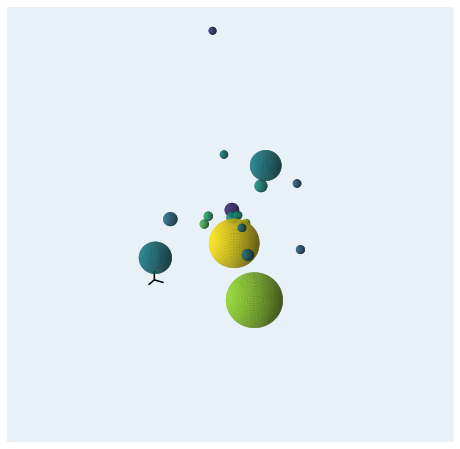

torch.Size([1, 20, 1]) torch.Size([1, 400])


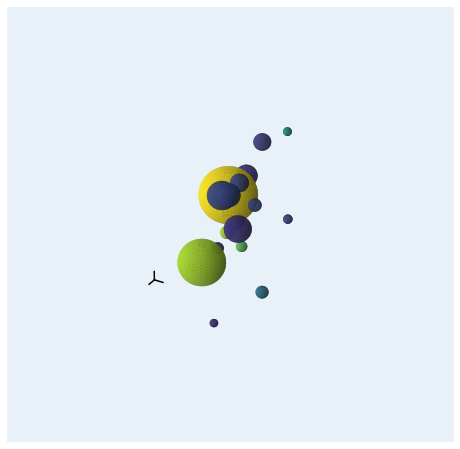

torch.Size([1, 20, 1]) torch.Size([1, 400])


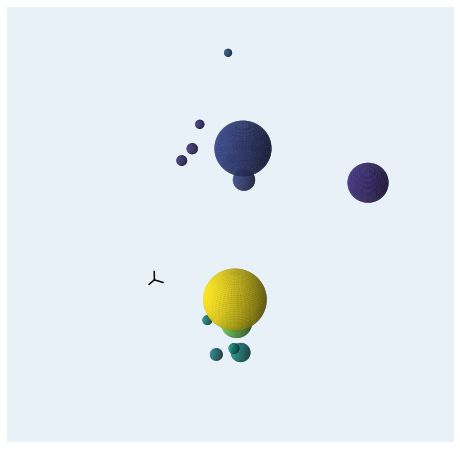

torch.Size([1, 20, 1]) torch.Size([1, 400])


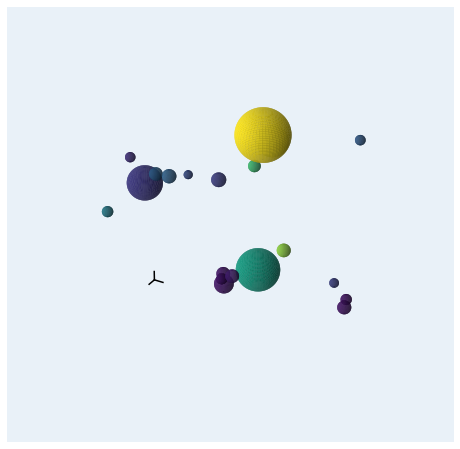

torch.Size([1, 20, 1]) torch.Size([1, 400])


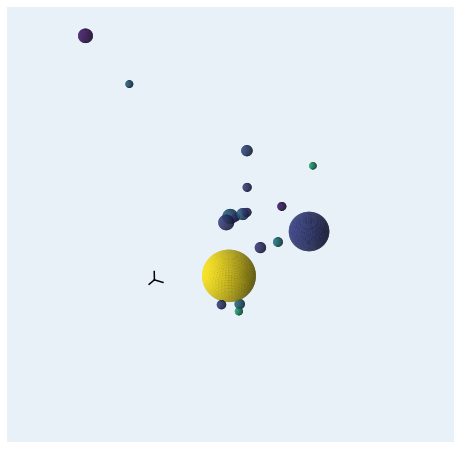

In [ ]:
import matplotlib

for i in range(5):
  xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak1)
  idx = 0
  XX = xpos_tweak1
  MM = feat_tweak1

  pos = XX[idx,:,:]*300
  radii = (np.exp(MM[idx,:,0]))**(1/3)



  norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
  cmap = matplotlib.cm.get_cmap('viridis')

  z = 1/MM[idx,:,1]-1
  colors = cmap(norm(z))

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')

  width = 600*2
  ax.set_xlim(-width, width)
  ax.set_ylim(-width, width)
  ax.set_zlim(-width, width)

  ax.set_facecolor(c0_rgba_01)
  #ax.xaxis.pane.set_edgecolor('#D0D0D0')
  ax.xaxis.pane.set_alpha(0)
  ax.yaxis.pane.set_alpha(0)
  ax.zaxis.pane.set_alpha(0)
  ax._axis3don = False

  # ax.xaxis.pane.set_alpha(0)
  # ax.xaxis.pane.set_facecolor("C1")
  # ax.yaxis.pane.set_facecolor("C1")
  # ax.zaxis.pane.set_facecolor("C1")

  # Hide grid lines
  ax.grid(False)

  # Hide axes ticks
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])

  # ax.yaxis.pane.set_alpha(0)
  # ax.zaxis.pane.set_alpha(0)

  # ax.grid(False)

  x, y, z = pos[:,0], pos[:,1], pos[:,2]


  ax.plot(xs=[-6*100,-5*100], ys = [-6*100,-6*100], zs=-6*100, zdir='z',color='k')
  ax.plot(ys=[-6*100,-5*100], xs = [-6*100,-6*100], zs=-6*100, zdir='y',color='k')
  ax.plot(ys=[-6*100,-7*100], xs = [-6*100,-6*100], zs=-6*100, zdir='k',color='k')

  plots = []
  for i, j, k, s, c in zip(x, y, z, radii, colors):
    # print(i,j,k,s,c)
    plots.append(draw_sphere(ax, i.item(), j.item(), k.item(), s.item()*50, c))
  plt.show()
  plt.close(fig)

torch.Size([1, 20, 1]) torch.Size([1, 400])


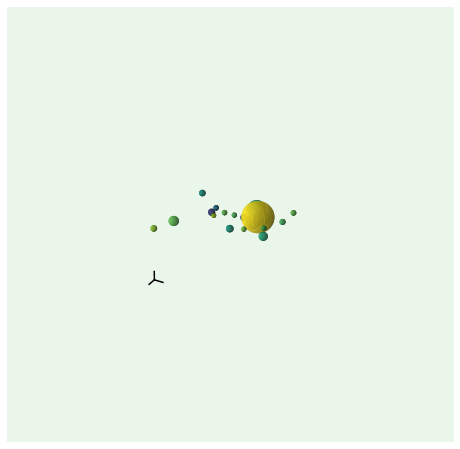

torch.Size([1, 20, 1]) torch.Size([1, 400])


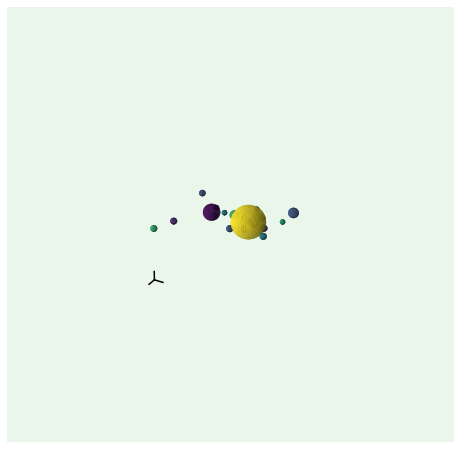

torch.Size([1, 20, 1]) torch.Size([1, 400])


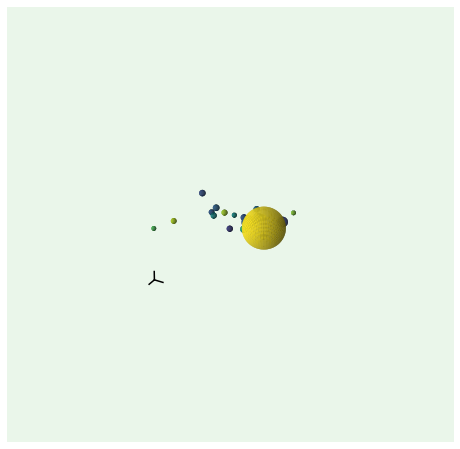

torch.Size([1, 20, 1]) torch.Size([1, 400])


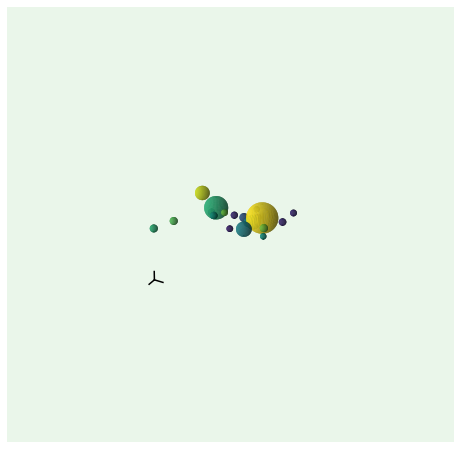

torch.Size([1, 20, 1]) torch.Size([1, 400])


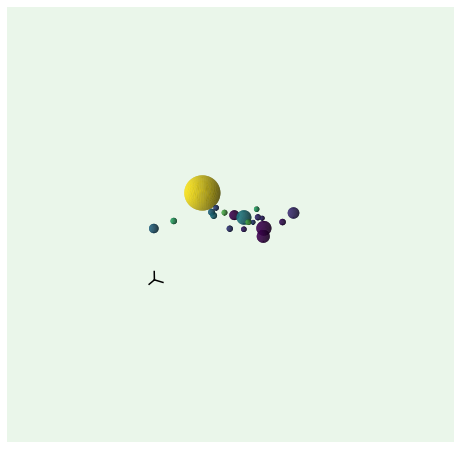

In [ ]:
import matplotlib

for i in range(5):
  xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)
  idx = 0
  XX = xpos_tweak1
  MM = feat_tweak1

  pos = XX[idx,:,:]*300
  radii = (np.exp(MM[idx,:,0]))**(1/3)



  norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
  cmap = matplotlib.cm.get_cmap('viridis')

  z = 1/MM[idx,:,1]-1
  colors = cmap(norm(z))

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')


  width = 600*2
  ax.set_xlim(-width, width)
  ax.set_ylim(-width, width)
  ax.set_zlim(-width, width)

  ax.set_facecolor(c2_rgba_01)
  #ax.xaxis.pane.set_edgecolor('#D0D0D0')
  ax.xaxis.pane.set_alpha(0)
  ax.yaxis.pane.set_alpha(0)
  ax.zaxis.pane.set_alpha(0)
  ax._axis3don = False

  # Hide grid lines
  # ax.grid(False)

  # Hide axes ticks
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])


  # ax.xaxis.pane.set_alpha(0)
  # ax.yaxis.pane.set_alpha(0)
  # ax.zaxis.pane.set_alpha(0)

  ax.plot(xs=[-6*100,-5*100], ys = [-6*100,-6*100], zs=-6*100, zdir='z',color='k')
  ax.plot(ys=[-6*100,-5*100], xs = [-6*100,-6*100], zs=-6*100, zdir='y',color='k')
  ax.plot(ys=[-6*100,-7*100], xs = [-6*100,-6*100], zs=-6*100, zdir='k',color='k')
  # ax.plot(y=[-5,-4], z = [-5,-5], xs=-5)
  # ax.plot(x=[-5,-4], z = [-5,-5], ys=-5)

  # plt.axis('off')

  # ax.grid(False)

  # x, y, z = pos[:,0], pos[:,1], pos[:,2]

  plots = []
  for i, j, k, s, c in zip(x, y, z, radii, colors):
    # print(i,j,k,s,c)
    plots.append(draw_sphere(ax, i.item(), j.item(), k.item(), s.item()*50, c))
  plt.show()
  plt.close(fig)
  # break

torch.Size([1, 20, 1]) torch.Size([1, 400])


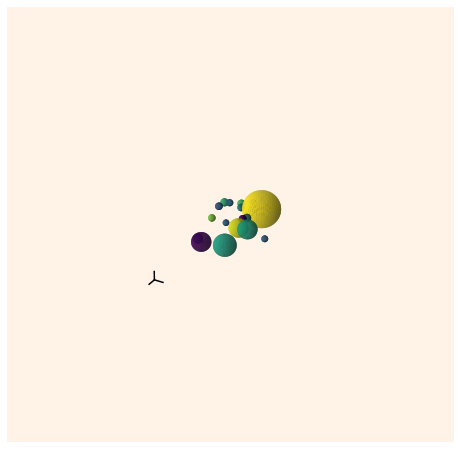

torch.Size([1, 20, 1]) torch.Size([1, 400])


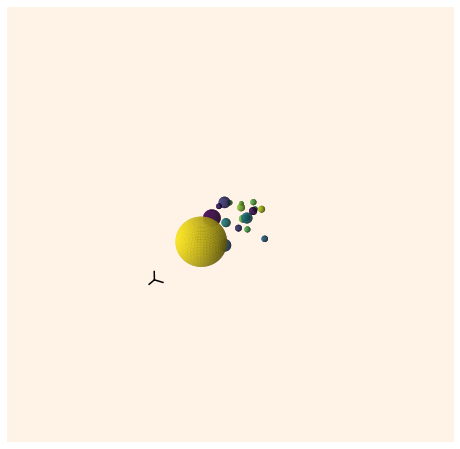

torch.Size([1, 20, 1]) torch.Size([1, 400])


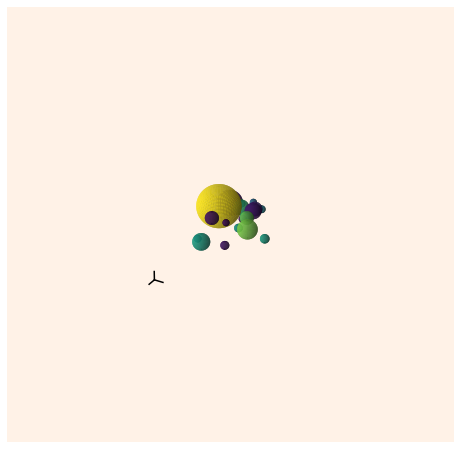

torch.Size([1, 20, 1]) torch.Size([1, 400])


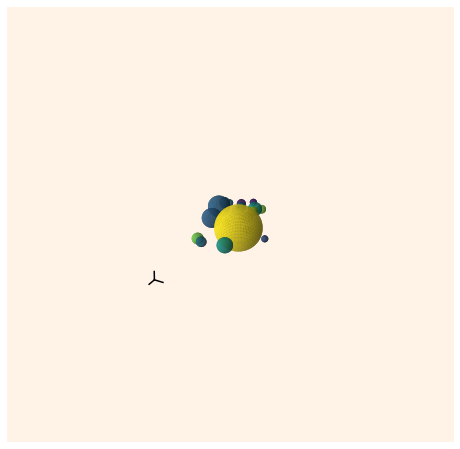

torch.Size([1, 20, 1]) torch.Size([1, 400])


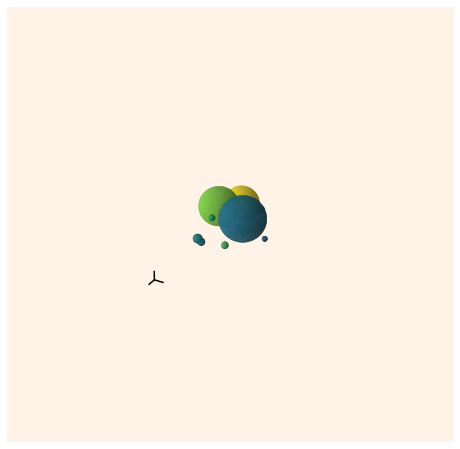

In [ ]:
import matplotlib

for i in range(5):
  # xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, context_tweak2)
  xpos_tweak1, feat_tweak1 = sample_from_flows_with_context(prior, flow, node_mask, torch.from_numpy(truth_cond))
  idx = 0
  XX = xpos_tweak1
  MM = feat_tweak1

  pos = XX[idx,:,:]*300
  radii = (np.exp(MM[idx,:,0]))**(1/3)



  norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
  cmap = matplotlib.cm.get_cmap('viridis')

  z = 1/MM[idx,:,1]-1
  colors = cmap(norm(z))

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')


  width = 600*2
  ax.set_xlim(-width, width)
  ax.set_ylim(-width, width)
  ax.set_zlim(-width, width)

  ax.set_facecolor(c1_rgba_01)
  #ax.xaxis.pane.set_edgecolor('#D0D0D0')
  ax.xaxis.pane.set_alpha(0)
  ax.yaxis.pane.set_alpha(0)
  ax.zaxis.pane.set_alpha(0)
  ax._axis3don = False

  # Hide grid lines
  # ax.grid(False)

  # Hide axes ticks
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])


  # ax.xaxis.pane.set_alpha(0)
  # ax.yaxis.pane.set_alpha(0)
  # ax.zaxis.pane.set_alpha(0)

  ax.plot(xs=[-6*100,-5*100], ys = [-6*100,-6*100], zs=-6*100, zdir='z',color='k')
  ax.plot(ys=[-6*100,-5*100], xs = [-6*100,-6*100], zs=-6*100, zdir='y',color='k')
  ax.plot(ys=[-6*100,-7*100], xs = [-6*100,-6*100], zs=-6*100, zdir='k',color='k')
  # ax.plot(y=[-5,-4], z = [-5,-5], xs=-5)
  # ax.plot(x=[-5,-4], z = [-5,-5], ys=-5)

  # plt.axis('off')

  # ax.grid(False)

  # x, y, z = pos[:,0], pos[:,1], pos[:,2]

  plots = []
  for i, j, k, s, c in zip(x, y, z, radii, colors):
    # print(i,j,k,s,c)
    plots.append(draw_sphere(ax, i.item(), j.item(), k.item(), s.item()*50, c))
  plt.show()
  plt.close(fig)
  # break

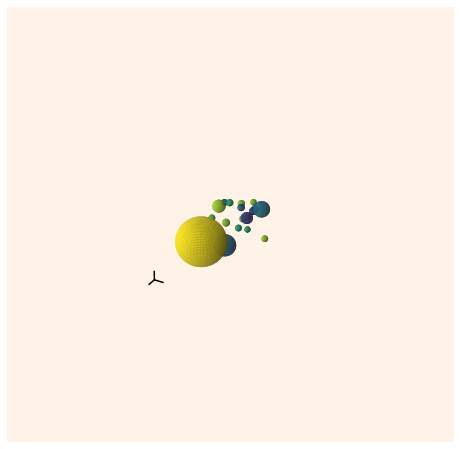

In [ ]:
pos = input_graph[0]
radii = input_graph[1][:,0]**(1/3)


norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
cmap = matplotlib.cm.get_cmap('viridis')

# z = 1/MM[idx,:,1]-1
z = input_graph[1][:,1]

colors = cmap(norm(z))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


width = 600*2
ax.set_xlim(-width, width)
ax.set_ylim(-width, width)
ax.set_zlim(-width, width)

ax.set_facecolor(c1_rgba_01)
#ax.xaxis.pane.set_edgecolor('#D0D0D0')
ax.xaxis.pane.set_alpha(0)
ax.yaxis.pane.set_alpha(0)
ax.zaxis.pane.set_alpha(0)
ax._axis3don = False

# Hide grid lines
# ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


# ax.xaxis.pane.set_alpha(0)
# ax.yaxis.pane.set_alpha(0)
# ax.zaxis.pane.set_alpha(0)

ax.plot(xs=[-6*100,-5*100], ys = [-6*100,-6*100], zs=-6*100, zdir='z',color='k')
ax.plot(ys=[-6*100,-5*100], xs = [-6*100,-6*100], zs=-6*100, zdir='y',color='k')
ax.plot(ys=[-6*100,-7*100], xs = [-6*100,-6*100], zs=-6*100, zdir='k',color='k')
# ax.plot(y=[-5,-4], z = [-5,-5], xs=-5)
# ax.plot(x=[-5,-4], z = [-5,-5], ys=-5)

# plt.axis('off')

# ax.grid(False)

# x, y, z = pos[:,0], pos[:,1], pos[:,2]

plots = []
for i, j, k, s, c in zip(x, y, z, radii, colors):
  # print(i,j,k,s,c)
  plots.append(draw_sphere(ax, i.item(), j.item(), k.item(), s.item()*50, c))
plt.show()
plt.close(fig)
# break

In [ ]:
input_graph[1][:,1]

tensor([2.0020, 1.5312, 0.6761, 0.7574, 1.7436, 0.4403, 0.4403, 1.6667, 0.7574,
        0.7911, 1.3024, 1.6667, 0.7574, 1.5312, 1.6042, 1.2485, 1.7436, 1.6667,
        1.6667, 1.3024], dtype=torch.float64)

# Now keep everything fix
- move the distance
- move the mass

In [ ]:
from HaloEGNN.HaloEGNNFlows.EGNNFlows.utils import subtract_the_boundary
from HaloEGNN.HaloEGNNFlows.EGNNFlows.flows.utils import assert_mean_zero_with_mask, remove_mean_with_mask,\
        assert_correctly_masked

def flow_logpx(flow,
                 prior,
                 input_graph,
                 input_cond,
                 device='cuda',
                 x_norm=300,
                 ode_regularization=0.01,
               return_z=False):
    x, h, node_mask, edge_mask = input_graph
    context = input_cond[0]
    # print(context.shape, node_mask.shape)

    x = x.to(device)
    h = h.to(device)
    node_mask = node_mask.to(device)
    edge_mask = edge_mask.to(device)
    context   = context.to(device)

    subtract_the_boundary(x, node_mask)
    xx = remove_mean_with_mask(x, node_mask)
    # print(xx)
    # h = log_normalize_with_mask(h, node_mask)

    h = (h+1e-8).log()* node_mask
    # dont normalize here
    #context = log_norm_target(context)
    # print(h)
    # center the position coordinate
    xx = remove_mean_with_mask(x/x_norm, node_mask)
    assert_mean_zero_with_mask(xx, node_mask)

    bs, n_nodes, n_dims = xx.size()
    # inflate context (condition) in to the shape of [batch, max_nodes, n_context]
    context_ = context.unsqueeze(1).repeat(1, n_nodes, 1)* node_mask
    assert_correctly_masked(context_, node_mask)

    xh = torch.cat([xx, h], dim=2)
    assert_correctly_masked(xh, node_mask)

    edge_mask = edge_mask.view(bs, n_nodes * n_nodes)


    z, delta_logp, reg_term = flow(xh.float(),
                                   node_mask.float(),
                                   edge_mask.float(),
                                   context_.float())
    z_x, z_h = z[:, :, 0:n_dims].clone(), z[:, :, n_dims:].clone()

    assert_correctly_masked(z_x, node_mask)
    assert_correctly_masked(z_h, node_mask)

    N = node_mask.squeeze(2).sum(1).long()

    log_qh_x = 0
    log_pz = prior(z_x, z_h, node_mask)
    log_px = (log_pz + delta_logp - log_qh_x)  # Average over batch.
    if not return_z:
      return log_px
    
    return log_px, z_x, z_h

@torch.no_grad()
def condition_log_prob(input_cond_np, input_graph, flow, prior, rtol=1e-4, trace_method='exact',device='cpu'):
  # we assume the graph is properly transformed already!
  flow.training = False
  flow.transformations[1]._rtol = rtol
  flow.transformations[1]._atol = rtol
  flow.transformations[1].odefunc.method = trace_method
  flow.transformations[1].odefunc.ode_regularization = 0.0

  input_cond = [ torch.from_numpy(input_cond_np).unsqueeze(0) ]
  logpx = flow_logpx(
    flow, 
    prior, 
    input_graph, 
    input_cond, 
    device=device, 
    ode_regularization=0.01
  )
  return logpx.cpu().numpy()

In [ ]:
from HaloEGNN.HaloEGNNFlows.train import *

In [ ]:
dl_train, dl_val, dl_test = prepare_dataloaders(
    sorted(valid_files),
    condition_columns,
    data_columns,
    position_columns=position_columns,
    feature_columns=feature_columns,
    max_progenitors=20,
    initial_slice=0,
    final_slice=1,
    batch_size=1,
    num_workers=0,
    random_seed=42,
    train_test_split=[0.8, 0.1, 0.1],
    shuffle_train=True,
    distributed=False,
)

# val_step(flow, prior, dl_val, condition_normalizer, device="cpu", ode_regularization=1e-2, transform_input=transform_input)

In [ ]:
flow.transformations[1].odefunc.before_odeint

<bound method ODEfunc.before_odeint of ODEfunc(
  (dynamics): EGNN_dynamics_QM9(
    (egnn): EGNN(
      (embedding): Linear(in_features=11, out_features=32, bias=True)
      (embedding_out): Linear(in_features=32, out_features=11, bias=True)
      (gcl_0): E_GCL(
        (edge_mlp): Sequential(
          (0): Linear(in_features=66, out_features=32, bias=True)
          (1): SiLU()
          (2): Linear(in_features=32, out_features=32, bias=True)
          (3): SiLU()
        )
        (node_mlp): Sequential(
          (0): Linear(in_features=64, out_features=32, bias=True)
          (1): SiLU()
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
        (coord_mlp): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): SiLU()
          (2): Linear(in_features=32, out_features=1, bias=False)
          (3): Tanh()
        )
        (att_mlp): Sequential(
          (0): Linear(in_features=32, out_features=1, bias=True)
      

In [ ]:
flow_

In [ ]:
flow.transformations[1].odefunc.method = 'exact'
total_loss = torch.zeros(1, device=device)
total_nll  = torch.zeros(1, device=device)

for input_graph, input_cond in dl_test:
    input_cond = [ torch.from_numpy(condition_normalizer.transform(input_cond[0])) ]
    input_graph = transform_input(input_graph)
    nll, loss, z_x, z_h = flow_forward(flow, prior, input_graph, input_cond, device=device, ode_regularization=0.01)
    total_loss += loss.item()
    total_nll  += nll.item()
    # count += 1
    break

In [ ]:
input_graph

(tensor([[[82697.7188, 92852.9453, 61752.8672],
          [82747.0781, 92560.9141, 62062.3711],
          [82690.5469, 92801.5156, 61729.0391],
          [82691.6016, 92752.3516, 61959.3398],
          [82422.3594, 92182.4141, 62023.8438],
          [82889.7266, 92985.1875, 62049.1484],
          [82778.5234, 92801.4609, 61749.4844],
          [82840.4609, 93302.7031, 62392.4609],
          [82404.0547, 92727.9922, 61342.3281],
          [82835.1719, 92538.4688, 61424.0195],
          [82819.7734, 92834.7109, 61797.8281],
          [82454.5859, 92511.9688, 61301.5078],
          [82806.3203, 93246.7109, 62251.4375],
          [82522.1094, 92174.2969, 62279.1992],
          [82570.3203, 92878.5781, 61649.2695],
          [82724.4531, 92319.1328, 62084.2617],
          [82401.8281, 92033.7344, 62243.5625],
          [82729.6875, 93002.9062, 61989.7305],
          [82586.5156, 92626.4375, 61463.5781],
          [82343.9844, 92478.2500, 61295.6484]]], dtype=torch.float64),
 tensor([[[64.47

In [ ]:
flow.transformations[1].odefunc.method = 'exact'
total_loss = torch.zeros(1, device=device)
total_nll  = torch.zeros(1, device=device)

for input_graph, input_cond in dl_test:
    input_cond = [ torch.from_numpy(condition_normalizer.transform(input_cond[0])) ]
    input_graph = transform_input(input_graph)
    nll, loss, z_x, z_h = flow_forward(flow, prior, input_graph, input_cond, device=device, ode_regularization=0.01)
    total_loss += loss.item()
    total_nll  += nll.item()
    # count += 1
    break
    
z = torch.cat([z_x, z_h], dim=2).float()

input_condnew = [torch.tensor([[ 0.9526, -0.8591, -0.6498,  0.1759,  1.1492, 3.1993,  -3.0405,  0.7633]],
        dtype=torch.float64)]

tmp = flow.reverse(z, input_graph[2], input_graph[3].long(), input_condnew[0].repeat(20,1).float() )
x    = tmp[:, :, 0:3].cpu().detach().numpy()
feat = tmp[:, :, 3:].cpu().detach().numpy()

In [ ]:
input_cond

[tensor([[ 0.9526, -0.8591, -0.6498,  0.1759,  1.1492, -5.1993,  1.0405,  0.7633]],
        dtype=torch.float64)]

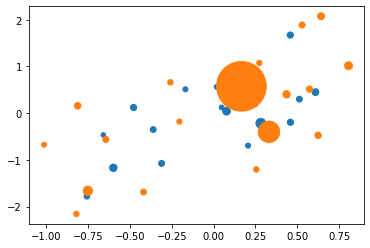

In [ ]:
plt.scatter(x[0][:,0],x[0][:,1], s= np.exp(feat[0,:,0])**(1/1.3)*100)
XX = input_graph[0][0,:,0]
YY = input_graph[0][0,:,1]
M  = input_graph[1][0,:,0]
XX = XX - XX.mean()
YY = YY - YY.mean()
plt.scatter(XX/300, YY/300, s=M**(1/1.3)*100)

(array([10.,  5.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([-2.020694  , -1.3710304 , -0.7213669 , -0.07170331,  0.57796025,
         1.2276238 ,  1.8772874 ,  2.5269508 ,  3.1766145 ,  3.8262782 ,
         4.4759417 ], dtype=float32),
 <a list of 10 Patch objects>)

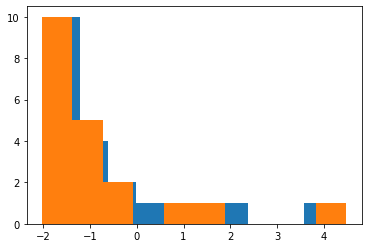

In [ ]:
plt.hist(np.log(M))
plt.hist(feat[0,:,0])

In [ ]:
z_x

tensor([[[ 0.1695,  1.3187, -0.5093],
         [ 0.6924, -0.4264,  0.8426],
         [ 0.1729,  0.3821, -0.5916],
         [-0.1164,  0.2027,  0.5788],
         [-0.9810, -1.4776,  0.2542],
         [ 1.1358,  0.8332,  0.6584],
         [ 0.5595,  0.3688, -0.4024],
         [ 0.4550,  1.7270,  1.7416],
         [-0.9809,  0.4851, -1.3984],
         [ 1.1250, -0.6556, -1.5119],
         [ 1.2347,  0.4482, -0.0783],
         [-0.5044, -0.6398, -1.6465],
         [ 0.2009,  1.7777,  1.1467],
         [-0.4902, -1.6664,  1.8210],
         [-0.7908,  0.9320, -0.7747],
         [ 0.6056, -1.2448,  0.6246],
         [-1.2011, -2.4651,  1.4543],
         [ 0.0928,  1.2203,  0.7588],
         [-0.1655, -0.3355, -1.3766],
         [-1.2139, -0.7846, -1.5913]]], grad_fn=<CloneBackward0>)

(array([ 1.,  2.,  8.,  5.,  9.,  4., 10., 10.,  6.,  5.]),
 array([-2.4650764 , -2.036467  , -1.6078577 , -1.1792483 , -0.75063896,
        -0.3220296 ,  0.10657978,  0.53518915,  0.9637985 ,  1.3924079 ,
         1.8210173 ], dtype=float32),
 <a list of 10 Patch objects>)

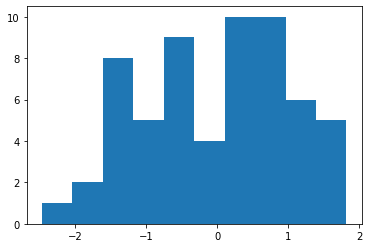

In [ ]:
import matplotlib.pyplot as plt
plt.hist(z_x[:,:].detach().numpy().flatten())

(array([ 3.,  4.,  5., 11., 10.,  2.,  1.,  2.,  1.,  1.]),
 array([-1.4653257 , -1.111604  , -0.7578822 , -0.40416038, -0.05043862,
         0.30328315,  0.65700495,  1.0107267 ,  1.3644484 ,  1.7181703 ,
         2.071892  ], dtype=float32),
 <a list of 10 Patch objects>)

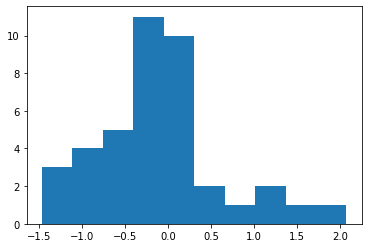

In [ ]:
plt.hist(z_h[:,:].detach().numpy().flatten())

In [ ]:
# dl_train, dl_val, dl_test = prepare_dataloaders(
#     valid_files,
#     condition_columns,
#     data_columns,
#     position_columns=position_columns,
#     feature_columns=feature_columns,
#     max_progenitors=20,
#     initial_slice=0,
#     final_slice=1,
#     batch_size=1,
#     num_workers=0,
#     random_seed=42,
#     train_test_split=[0.8, 0.1, 0.1],
#     shuffle_train=True,
#     distributed=False,
# )

In [ ]:
graph1, cond1 = preprocess_inputs(dataset, 0)

NameError: ignored

In [ ]:
condition_normalizer.transform(dataset[0][1][0].unsqueeze(0))

array([[ 1.27806885, -0.03799566, -0.47217386, -0.19013125,  1.61417771,
         0.29818278,  1.27317381,  1.52268455]])

In [ ]:
dataset[0][1]

[tensor([1.3792e-02, 3.0449e-05, 9.2447e-03, 1.8021e-02, 1.4314e+02, 8.9074e-01,
         2.2534e+02, 1.3408e+02], dtype=torch.float64)]

In [ ]:
flow.transformations[1].odefunc.method = 'exact'

In [ ]:
log_px, z_x, z_h = flow_logpx(flow, prior, graph1, cond1, return_z=True, device='cpu')

(array([ 1.,  3.,  3., 10.,  2.,  8., 13.,  7.,  7.,  6.]),
 array([-2.5040975 , -2.0797787 , -1.65546   , -1.2311412 , -0.8068224 ,
        -0.3825037 ,  0.04181506,  0.46613383,  0.89045256,  1.3147713 ,
         1.7390901 ], dtype=float32),
 <a list of 10 Patch objects>)

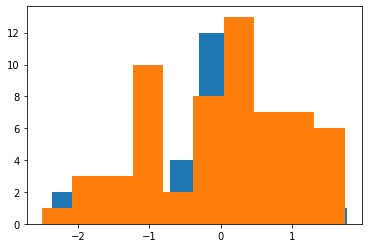

In [ ]:
plt.hist(z_h.detach().flatten().numpy())
plt.hist(z_x.detach().flatten().numpy())

In [ ]:
flow_forward??

In [ ]:
nll, loss, z_x, z_h = flow_forward(flow, prior, graph1, cond1 )

In [ ]:
transform_input??

In [ ]:
ddd = next(iter(dl_val))
graph1 = ddd[0]
cond1 = ddd[1]

# tensor([[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  0.4758]],
#        dtype=torch.float64)
input_cond = [ torch.from_numpy(condition_normalizer.transform(cond1[0])) ]

input_cond = [torch.tensor(
    [[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  3]],
    dtype=torch.float64)]

tgraph = transform_input(graph1)

trace_method='exact'
flow.transformations[1].odefunc.method = trace_method

nll, loss, _, _ = flow_forward(flow, prior, tgraph, input_cond, device=device, ode_regularization=1e-2)
print(nll)

tensor(4.7104, grad_fn=<NegBackward0>)


In [ ]:
graph1[1]

tensor([[[41.7171,  1.3953],
         [ 1.5536,  2.0853],
         [ 0.7819,  1.4398],
         [ 0.7663,  1.6048],
         [ 0.6949,  2.2348],
         [ 0.4358,  1.5132],
         [ 0.3803,  1.9637],
         [ 0.2247,  1.5601],
         [ 0.1804,  1.4681],
         [ 0.1394,  1.4929],
         [ 0.1390,  1.4111],
         [ 0.0956,  1.4398],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183]]], dtype=torch.float64)

In [ ]:
ddd = next(iter(dl_val))
graph1 = ddd[0]
cond1 = ddd[1]

# tensor([[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  0.4758]],
#        dtype=torch.float64)
input_cond = [ torch.from_numpy(condition_normalizer.transform(cond1[0])) ]
# input_cond = torch.tensor(
#     [[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  3]],
#     dtype=torch.float64)
print(input_cond)
tgraph =  add_noise2mass(transform_input(graph1), mag=0.1)

trace_method='exact'
flow.transformations[1].odefunc.method = trace_method

nll, loss, _, _ = flow_forward(flow, prior, tgraph, input_cond, device=device, ode_regularization=1e-2)
print(nll)

[tensor([[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  0.4758]],
       dtype=torch.float64)]
tensor(0.8763, grad_fn=<NegBackward0>)


In [ ]:
ddd = next(iter(dl_train))
graph1 = ddd[0]
cond1 = ddd[1]

# tensor([[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  0.4758]],
#        dtype=torch.float64)
input_cond = [ torch.from_numpy(condition_normalizer.transform(cond1[0])) ]
# input_cond = torch.tensor(
#     [[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  3]],
#     dtype=torch.float64)
print(input_cond)
tgraph =  add_noise2mass(transform_input(graph1), mag=1.1)

trace_method='exact'
flow.transformations[1].odefunc.method = trace_method

nll, loss, _, _ = flow_forward(flow, prior, tgraph, input_cond, device=device, ode_regularization=1e-2)
print(nll)

[tensor([[ 2.2474e+00, -1.1736e+00, -5.1993e+00,  1.8446e-01, -1.4175e+00,
         -5.1993e+00,  1.2689e+00,  1.0996e+00],
        [ 1.7600e+00, -3.5896e-01, -5.6004e-01,  1.5692e+00,  1.0169e+00,
          8.2655e-01,  1.6836e+00,  1.7694e+00],
        [ 9.5124e-01, -1.1637e+00,  1.4732e-01,  2.0044e-01, -2.0663e+00,
         -5.1993e+00,  6.2864e-01,  5.6816e-01],
        [ 1.9881e-01,  9.0680e-01,  1.4324e+00, -1.0722e-01, -4.2251e-02,
          1.3846e+00,  3.2310e-01,  7.2231e-01],
        [ 7.5131e-01, -1.8005e-01, -5.6622e-01,  6.1015e-01,  6.1806e-01,
         -5.1993e+00,  3.5644e-01,  7.3688e-01],
        [-2.2464e+00, -1.1798e+00, -1.1470e+00, -1.6291e+00, -4.7282e-01,
          2.1197e-01, -6.3911e-01, -7.1836e-01],
        [-3.2603e-01,  8.7722e-01,  4.1060e-01,  8.1525e-01,  4.9864e-01,
          1.4269e+00,  8.8389e-02, -2.8997e-02],
        [-1.0926e+00, -1.2253e+00,  1.2005e+00, -7.4863e-01, -8.4279e-01,
         -5.7314e-01, -7.9258e-01, -9.6943e-01],
        [-7.739

NameError: ignored

In [ ]:
tgraph[1]

tensor([[[41.7171,  1.3953],
         [ 1.5536,  2.0853],
         [ 0.8600,  1.4398],
         [ 0.7663,  1.6048],
         [ 0.6949,  2.2348],
         [ 0.4358,  1.5132],
         [ 0.3803,  1.9637],
         [ 0.2247,  1.5601],
         [ 0.1804,  1.4681],
         [ 0.1394,  1.4929],
         [ 0.1390,  1.4111],
         [ 0.0956,  1.4398],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183],
         [ 0.0000,  2.7183]]], dtype=torch.float64)

In [ ]:
def plot_graph(ax, graph):
  mass = (graph[1][0,:,0]) *10
  z = 1/graph[1][0,:,1].log() - 1
  x = graph[0][0,:,0]/300
  y = graph[0][0,:,1]/300
  
  
  x = x - x[0]
  y = y - y[0]

  
  flag = graph[2].flatten() > 0
  ax.scatter(x[flag], y[flag], s=mass[flag], c=z[flag])
  ax.set_aspect(1)

def add_noise2mass(input_graph, nidx=1, midx=0, mag=1.1):
  x, h, node_mask, edge_mask = input_graph
  h[:,nidx,midx] = h[:,nidx,midx]* mag
  return x, h, node_mask, edge_mask

In [ ]:
graph1[0][0][:,0]- graph1[0][0][0,0]

tensor([   0.0000,  141.7461,  174.0938,  308.1250,   90.2656, -162.4492,
          28.0352, -400.5898,  188.7188, -198.0898,   -3.3633, -176.3398,
         -97.2266,  612.0820,   68.3438,  127.9922, -265.4336,   65.9258,
        -206.9570,   27.5625], dtype=torch.float64)

In [ ]:
ddd = next(iter(dlidx))
graph1 = ddd[0]
cond1 = ddd[1]
print(graph1[1][0,3])
tgraph =  add_noise2mass(transform_input(graph1), mag=0.1, nidx=3)

print(tgraph[1][0,3])

tensor([3.7087, 0.1258], dtype=torch.float64)
tensor([0.3709, 2.4310], dtype=torch.float64)


In [ ]:
205*1e6/ 205000 

1000.0

In [ ]:
200811.3125 / 205000

0.9795673780487805

In [ ]:
preprocess_inputs(dataset,0)

((tensor([[[ 38274.3906,  52220.8477, 161317.0938],
           [ 39058.2109,  53160.5664, 161288.6875],
           [ 38966.3711,  52596.6953, 160960.9531],
           [ 38995.3828,  52008.5664, 160939.0625],
           [ 38231.2305,  52440.1367, 161517.7188],
           [ 38824.0273,  52521.6523, 161002.4531],
           [ 38781.1406,  52070.7734, 161012.4688],
           [ 39015.6602,  53185.4219, 161350.0312],
           [ 39021.3242,  53050.8047, 161126.7656],
           [ 38596.7422,  52342.0664, 161169.5156],
           [ 38271.0781,  52375.9219, 161323.4531],
           [ 38808.4258,  51869.4102, 161241.7031],
           [ 38927.4961,  53197.3906, 161561.5938],
           [ 37834.1562,  52417.8672, 161294.9688],
           [ 38746.7266,  52746.5742, 161232.5312],
           [ 38627.4922,  52566.6367, 161215.7188],
           [ 38333.8047,  51838.8828, 160973.0469],
           [ 38734.6641,  52754.7852, 161351.9375],
           [ 38701.2930,  51949.1133, 161554.6562],
           [

In [ ]:
graph1[0]

tensor([[[ 34235.7773, 200331.7188,   6526.5239],
         [ 33985.2617, 199872.4531,   6583.5273],
         [ 34563.6172, 200501.6250,   6890.2393],
         [ 34818.1484, 200201.1875,   6508.4312],
         [ 34012.4688, 199999.9219,   6553.3989],
         [ 34513.7773, 200811.3125,   7081.8545],
         [ 34797.5820, 200394.7812,   7044.7275],
         [ 34484.0586, 200756.9062,   6982.1787],
         [ 34147.6680, 200613.9062,   6434.7959],
         [ 34214.4727, 200381.5938,   6496.1987],
         [ 34566.4570, 200538.7969,   6918.5454],
         [ 34512.9922, 200836.8125,   6839.8999],
         [ 33983.9531, 199825.0312,   6611.7573],
         [ 34465.4922, 200869.9375,   6506.1528],
         [ 34300.3203, 200162.9531,   6584.1240],
         [ 34419.9023, 200369.1094,   6657.3027],
         [ 34426.3516, 200299.7969,   6628.2515],
         [ 34372.2422, 200123.5625,   7018.7358],
         [ 34085.9023, 200211.2344,   6535.5728],
         [ 34709.3516, 200371.7500,   6987.9121]]]

In [ ]:
from torch.utils.data import Subset,DataLoader
file_idx = 566
file_idx = 9826
dsidx = Subset(dataset, [file_idx])
dlidx = DataLoader(dsidx,shuffle=False, batch_size=1)


def nll_changes_mass(noise_mag=1.1, nidx=1):
  # ddd = next(iter(dlidx))
  ddd = next(iter(dlidx))
  graph1 = ddd[0]
  cond1 = ddd[1]

  # tensor([[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  0.4758]],
  #        dtype=torch.float64)
  input_cond = [ torch.from_numpy(condition_normalizer.transform(cond1[0])) ]
  tgraph =  add_noise2mass(transform_input(graph1), mag=noise_mag, nidx=nidx)

  trace_method='exact'
  flow.transformations[1].odefunc.method = trace_method
  # with torch.no_grad():
  nll, loss, _, _ = flow_forward(flow, prior, tgraph, input_cond, device=device, ode_regularization=1e-2)
  return tgraph, nll

In [ ]:
ddd = next(iter(dlidx))
graph1 = ddd[0]
cond1 = ddd[1]

input_cond = [ torch.from_numpy(condition_normalizer.transform(cond1[0])) ]
tgraph =  add_noise2mass(transform_input(graph1), mag=1.0, nidx=0)


trace_method='exact'
flow.transformations[1].odefunc.method = trace_method
# with torch.no_grad():
nll, loss, _, _ = flow_forward(flow, prior, tgraph, input_cond, device=device, ode_regularization=1e-2)


In [ ]:
nll

tensor(9.8884, grad_fn=<NegBackward0>)

0 tensor(6.0871, grad_fn=<NegBackward0>)
1 tensor(7.0264, grad_fn=<NegBackward0>)
2 tensor(8.1211, grad_fn=<NegBackward0>)
3 tensor(9.8884, grad_fn=<NegBackward0>)
4 tensor(13.1516, grad_fn=<NegBackward0>)
5 tensor(18.4557, grad_fn=<NegBackward0>)
6 tensor(24.0283, grad_fn=<NegBackward0>)


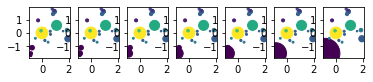

In [ ]:
import matplotlib.pyplot as plt


noises = [0.1,0.25,0.5,1, 2,4,8]
nlls   = np.zeros_like(noises)
graphs = []
f,ax=plt.subplots(1,len(noises))
for i, n in enumerate(noises):
  tgraph, nll = nll_changes_mass(n,  nidx=1)
  nlls[i] = nll
  graphs.append(tgraph)
  print(i, nll)
  plot_graph(ax[i], tgraph)

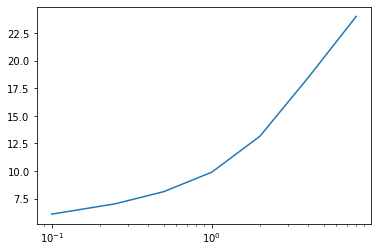

In [ ]:
plt.semilogx(noises, nlls)

In [ ]:
i1 = 1

def add_noise2pos(input_graph, dx, nidx=3):
  x, h, node_mask, edge_mask = input_graph
  x[0,nidx,:] = x[0,nidx,:] + dx
  return x, h, node_mask, edge_mask

def transform_graph(input_graph):
    # transform only the features
    if z_idx is None:
        return input_graph
    x, h, node_mask, edge_mask = input_graph
    h[:, :, z_idx] = 1 / (1 + h[:, :, z_idx])
    h[:, :, z_idx] = h[:, :, z_idx].exp()
    return x/300, h, node_mask, edge_mask


dx = torch.tensor([1,1,0])*100* i1*0.5
def nll_changes_pos(dx, nidx=1):
  # ddd = next(iter(dlidx))
  ddd = next(iter(dlidx))
  graph1 = ddd[0]
  cond1 = ddd[1]

  # tensor([[-0.0842,  1.4554,  0.8843, -0.1655,  0.5324,  1.5204,  0.5877,  0.4758]],
  #        dtype=torch.float64)
  input_cond = [ torch.from_numpy(condition_normalizer.transform(cond1[0])) ]
  # tgraph =  add_noise2mass(transform_input(graph1), mag=noise_mag, nidx=nidx)

  graph1 = transform_input(graph1)
  # graph1[0] = graph1[0]/300.

  tgraph =  add_noise2pos(graph1, dx= dx, nidx=nidx)

  trace_method='exact'
  flow.transformations[1].odefunc.method = trace_method
  # with torch.no_grad():
  nll, loss, _, _ = flow_forward(flow, prior, tgraph, input_cond, device=device, ode_regularization=1e-2)
  return tgraph, nll

In [ ]:
tgraph, nll = nll_changes_pos(dx=dx*0, nidx=0)

In [ ]:
ddd = next(iter(dlidx))
graph1 = ddd[0]
cond1 = ddd[1]

In [ ]:
zidx

1

0 tensor(27.3446, grad_fn=<NegBackward0>)
1 tensor(26.2305, grad_fn=<NegBackward0>)
2 tensor(23.3629, grad_fn=<NegBackward0>)
3 tensor(19.5625, grad_fn=<NegBackward0>)
4 tensor(10.0880, grad_fn=<NegBackward0>)
5 tensor(18.4910, grad_fn=<NegBackward0>)
6 tensor(21.9885, grad_fn=<NegBackward0>)
7 tensor(24.9045, grad_fn=<NegBackward0>)
8 tensor(27.3274, grad_fn=<NegBackward0>)


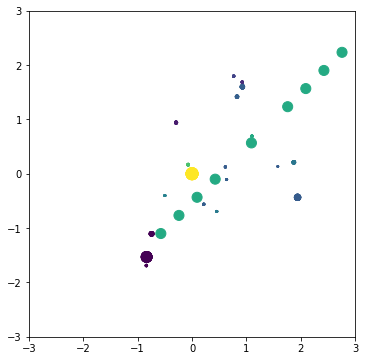

In [ ]:
# ddd = next(iter(dlidx))
# graph1 = ddd[0]
# cond1 = ddd[1]

# graph1, cond1= 

f,ax=plt.subplots(1,1, figsize=(6,6))

noises = [-5, -4, -3,-2,0,2,3,4, 5]
dx = torch.tensor([1,1,0])*100
nlls   = np.zeros_like(noises)
graphs = []
for i, lmult in enumerate(noises): #,2,3]):
  tgraph, nll = nll_changes_pos(dx=dx*lmult, nidx=2)
  # tgraph =  add_noise2pos(graph1, dx= torch.tensor([1,1,0])*100* i1*0.5, nidx=0)
  # print(graph1[0][0,0,:])
  plot_graph(ax,tgraph)
  ax.set_xlim(-3,3)
  ax.set_ylim(-3,3)
  nlls[i] = nll
  graphs.append(tgraph)
  print(i, nll)

In [ ]:
noises = np.array(noises)

(array([-30. , -27.5, -25. , -22.5, -20. , -17.5, -15. , -12.5, -10. ,
         -7.5]), <a list of 10 Text major ticklabel objects>)

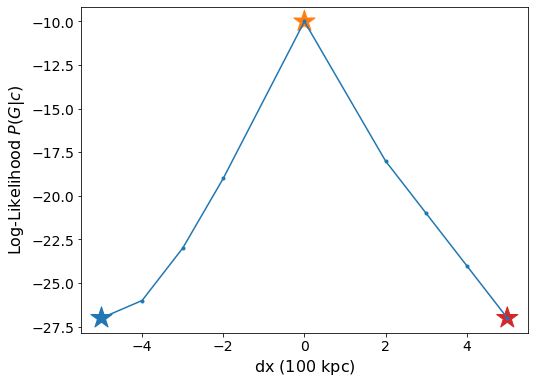

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(noises,-nlls,marker='.')
plt.scatter(noises[[0,4,-1]], -nlls[[0,4,-1]],marker='*',color = ['C0', 'C1', 'C3'], s = 500)
plt.ylabel(r"Log-Likelihood $P(G|c)$", fontsize=16)
plt.xlabel(r"$\rm dx$ (100 kpc)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
tgraph[0].numpy()[0][0]- tgraph[0].numpy()[0][1]

array([250.515625  , 459.265625  , -57.00341797])

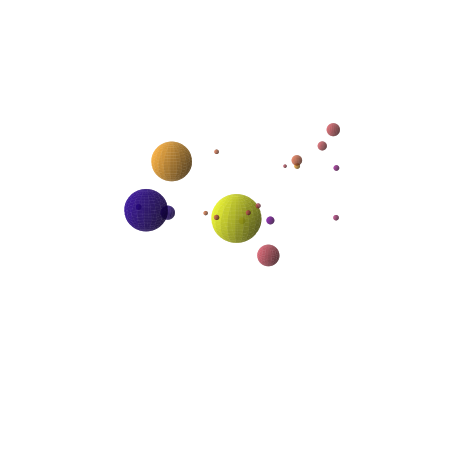

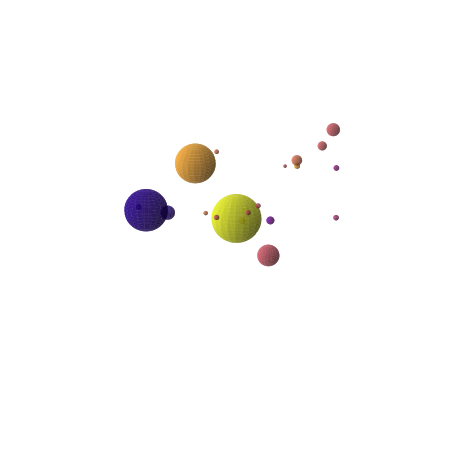

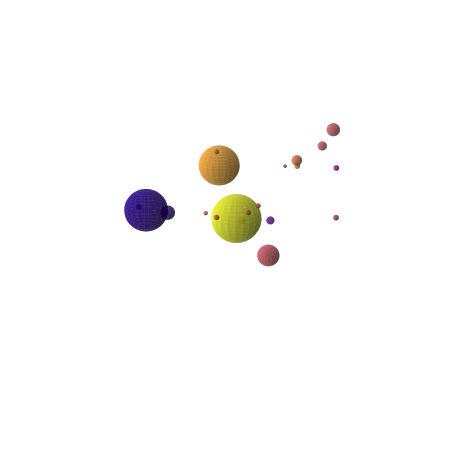

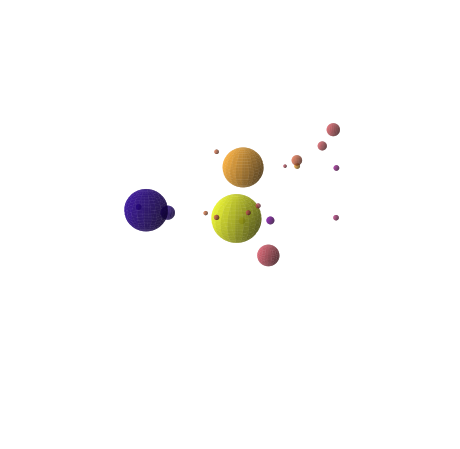

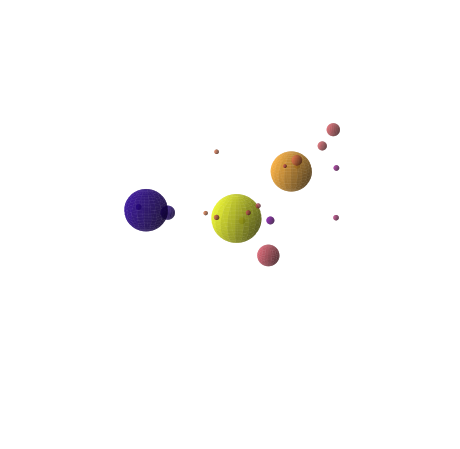

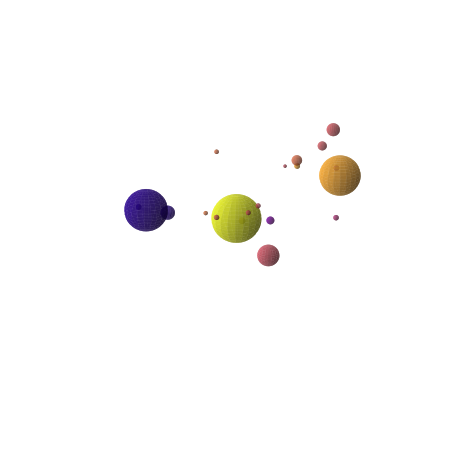

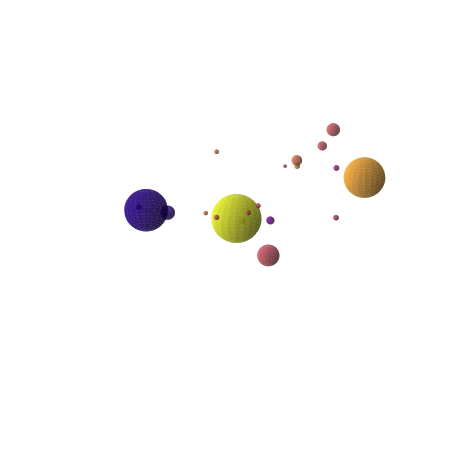

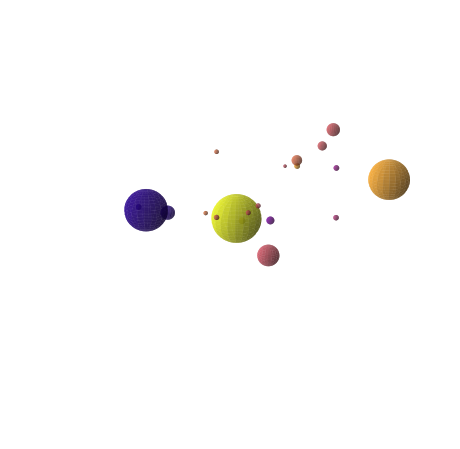

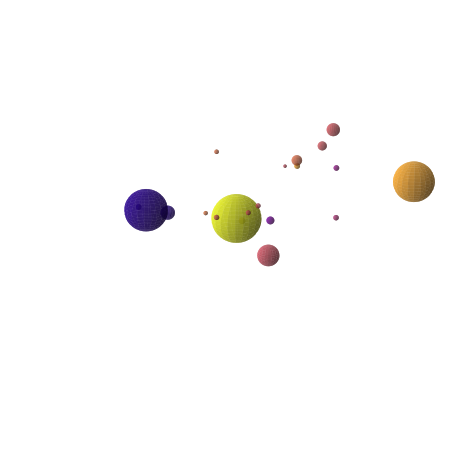

In [ ]:
for tgraph in graphs:
  # plot_pos_feat_3d(tgraph[0].numpy()/100, tgraph[1].log().numpy(), 
  #                 fc=None, azim=30, elev=-30, alpha=0.7, width=10, annotate=True, grid_on=False,
  #                 scale_size=5)
  
c0_rgba_01

In [ ]:
# plot_pos_feat_3d(tgraph[0].numpy()/300, tgraph[1].log().numpy(), 
#                  fc=c1_rgba_01, azim=30, elev=-30, alpha=0.7, width=1.8, annotate=True, grid_on=True,
#                  scale_size=1)

IndexError: ignored

NameError: ignored

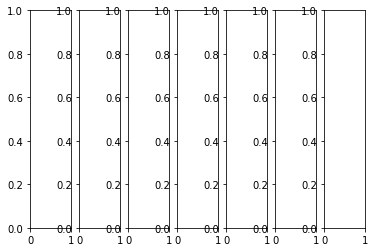

In [ ]:
import matplotlib.pyplot as plt


noises = [0.1,0.25,0.5,1, 2,4,8]
nlls   = np.zeros_like(noises)
graphs = []
f,ax=plt.subplots(1,len(noises))
for i, n in enumerate(noises):
  tgraph, nll = nll_changes_mass(n,  nidx=1)
  nlls[i] = nll
  graphs.append(tgraph)
  print(i, nll)
  plot_graph(ax[i], tgraph)

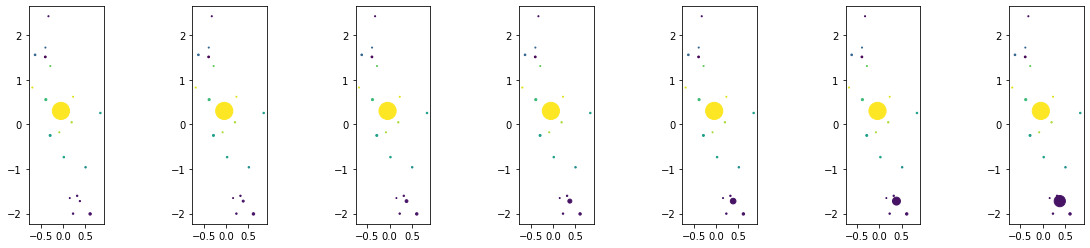

In [ ]:
f,ax=plt.subplots(1,len(noises),figsize=(20,4))
for i, g in enumerate(graphs):
  plot_graph(ax[i], g)

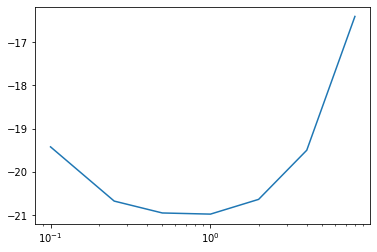

In [ ]:
plt.semilogx(noises, nlls)

In [ ]:
emcee.EnsembleSampler??


# Chain!

In [ ]:
def rotate_chain(z):
    assert z.size(0) == 1

    z_h = z[:, :, 3:]

    n_steps = 30
    theta = 0.6 * np.pi / n_steps
    Qz = torch.tensor(
        [[np.cos(theta), -np.sin(theta), 0.],
         [np.sin(theta), np.cos(theta), 0.],
         [0., 0., 1.]]
    ).float()

    theta = 0
    Qx = torch.tensor(
        [[1., 0., 0.],
         [0., np.cos(theta), -np.sin(theta)],
         [0., np.sin(theta), np.cos(theta)]]
    ).float()
    Qy = torch.tensor(
        [[np.cos(theta), 0., np.sin(theta)],
         [0., 1., 0.],
         [-np.sin(theta), 0., np.cos(theta)]]
    ).float()

    Q = torch.mm(torch.mm(Qz, Qx), Qy)

    Q = Q.to(z.device)

    results = []
    results.append(z)
    for i in range(n_steps):
        z_x = results[-1][:, :, :3]
        # print(z_x.size(), Q.size())
        new_x = torch.matmul(z_x.view(-1, 3), Q.T).view(1, -1, 3)
        # print(new_x.size())
        new_z = torch.cat([new_x, z_h], dim=2)
        results.append(new_z)

    results = torch.cat(results, dim=0)
    return results


def sample_chain(device, flow, prior, context):
    flow.set_trace('exact')

    n_samples, n_nodes, n_context = context.shape

    node_mask = torch.ones(n_samples, n_nodes, 1).to(device)

    edge_mask = (1 - torch.eye(n_nodes)).unsqueeze(0)
    edge_mask = edge_mask.repeat(n_samples, 1, 1).view(-1, 1).to(device)


    z_x, z_h = prior.sample(n_samples, n_nodes, node_mask)
    z = torch.cat([z_x, z_h], dim=2)

    tmp = flow.reverse(z, node_mask, edge_mask, context)
    x = tmp[:, :, 0:3]
    h = tmp[:, :, 3:]

    # DO NOT plot prior rotations, actnorm is missing.
    prior_rotations = rotate_chain(z)

    assert_mean_zero_with_mask(z_x, node_mask)

    zs = flow.reverse_chain(z, node_mask, edge_mask, context)
    zs_rotated = flow.reverse_chain(prior_rotations[-1:], node_mask, edge_mask, context)

    data_rotations = rotate_chain(zs[-1:])

    # This is the one we have to plot ;)
    prior_rotations_with_actnorm = rotate_chain(zs[0:1])

    def reverse_tensor(x):
        return x[torch.arange(x.size(0) - 1, -1, -1)]

    zs_rotated_rev = reverse_tensor(zs_rotated)
    prior_rotations_rev = reverse_tensor(prior_rotations_with_actnorm)

    z = torch.cat(
        [zs, data_rotations, zs_rotated_rev, prior_rotations_rev], dim=0
    )
    print(zs.shape, data_rotations.shape, zs_rotated_rev.shape, prior_rotations_rev.shape)
    x = z[:, :, :3]
    m = z[:, :, 3:]

    return x, m

In [ ]:
input_graph, input_cond = preprocess_inputs(dataset,9826)

nll, loss, z_x, z_h = flow_forward(flow, prior, input_graph, input_cond, device=device, ode_regularization=0.01)
z = torch.cat([z_x, z_h], dim=2).float().detach()


In [ ]:
tmp = flow.reverse_chain(z, node_mask= input_graph[2], edge_mask=input_graph[3].long(), context= input_cond[0].repeat(20,1).float() )
# tmp = tmp[:,0,:,:]
x_chain    = tmp[:, :, 0:3].cpu().detach().numpy()
feat_chain = tmp[:, :, 3:].cpu().detach().numpy()

In [ ]:
tmp.shape

torch.Size([50, 20, 5])

In [ ]:
for i in np.arange(50):
  # plot_pos_feat_3d(tgraph[0].numpy()/100, tgraph[1].log().numpy(), 
  #                 fc=None, azim=30, elev=-30, alpha=0.7, width=10, annotate=True, grid_on=False,
  #                 scale_size=5)
  
  f = plot_pos_feat_3d(x_chain[[i]]*300, feat_chain[[i]], 
                   fc=None, azim=20, elev=-30, alpha=0.7, width=1000, annotate=False, grid_on=False, scale_size=50, size_pow=1, return_fig=True, vmin=-2, vmax=2, logcolor=False)
  f.savefig(f"flow_chain_{i:2d}.png")
  plt.close(f)

NameError: ignored

In [ ]:
import glob
filelist = sorted(glob.glob("flow_chain_*.png"))

In [ ]:
import imageio
images = []
for filename in filelist:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)

In [ ]:
matplotlib.colors.Normalize()

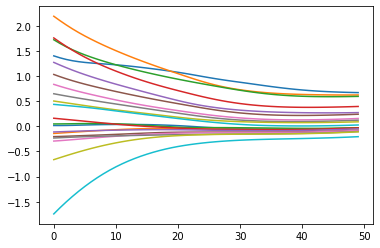

In [ ]:
for i in range(20):
  plt.plot(feat_chain[:,i,0])

In [ ]:
feat_chain[:,:,0].std(axis=1)

array([0.9225434 , 0.8781019 , 0.83649695, 0.7977623 , 0.7619557 ,
       0.7288374 , 0.6981495 , 0.66964656, 0.6430964 , 0.6182802 ,
       0.5949954 , 0.5730564 , 0.5523239 , 0.5327412 , 0.5142594 ,
       0.49682343, 0.48037115, 0.4648326 , 0.45012918, 0.43617287,
       0.4228662 , 0.41007072, 0.39756325, 0.38547257, 0.3739513 ,
       0.36311203, 0.35302728, 0.3437296 , 0.33521286, 0.32743323,
       0.3203095 , 0.31372312, 0.3075584 , 0.30186075, 0.29663065,
       0.29185545, 0.2875186 , 0.2835991 , 0.28007084, 0.27690253,
       0.27405763, 0.27149433, 0.2691657 , 0.26701334, 0.2649854 ,
       0.26306117, 0.26122165, 0.25944906, 0.25772682, 0.25603953],
      dtype=float32)

In [ ]:
feat_chain[:,:,1].std(axis=1)

array([0.6733484 , 0.65260977, 0.63478273, 0.6197656 , 0.6073353 ,
       0.5972703 , 0.58935827, 0.5833888 , 0.57915485, 0.57645744,
       0.5751128 , 0.5749714 , 0.57606125, 0.5783509 , 0.5817551 ,
       0.5861821 , 0.5915406 , 0.59774274, 0.6047043 , 0.6123436 ,
       0.62057835, 0.6293328 , 0.63860726, 0.6484491 , 0.6588868 ,
       0.6699295 , 0.6815702 , 0.69378716, 0.70654416, 0.7197867 ,
       0.7334391 , 0.7474017 , 0.76158714, 0.7760469 , 0.79078335,
       0.80579054, 0.82106423, 0.836601  , 0.8523992 , 0.8684576 ,
       0.88477635, 0.90135634, 0.91819894, 0.9352521 , 0.95245063,
       0.96986675, 0.98755896, 1.0055677 , 1.023917  , 1.042614  ],
      dtype=float32)

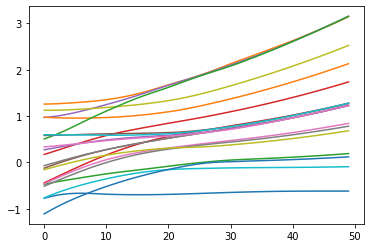

In [ ]:
for i in range(20):
  plt.plot(feat_chain[:,i,1])

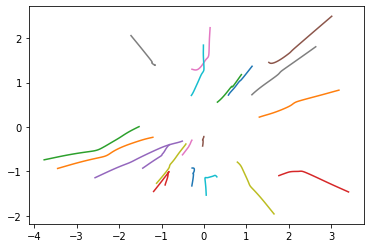

In [ ]:
for i in range(20):
  plt.plot(x_chain[:,i,1], x_chain[:,i,2])

In [ ]:
!zip -r chain.zip chain*.png

  adding: chain_ 0.png (deflated 7%)
  adding: chain_10.png (deflated 12%)
  adding: chain_11.png (deflated 12%)
  adding: chain_12.png (deflated 13%)
  adding: chain_13.png (deflated 13%)
  adding: chain_14.png (deflated 12%)
  adding: chain_15.png (deflated 12%)
  adding: chain_16.png (deflated 13%)
  adding: chain_17.png (deflated 13%)
  adding: chain_18.png (deflated 13%)
  adding: chain_19.png (deflated 14%)
  adding: chain_ 1.png (deflated 7%)
  adding: chain_20.png (deflated 14%)
  adding: chain_21.png (deflated 15%)
  adding: chain_22.png (deflated 14%)
  adding: chain_23.png (deflated 14%)
  adding: chain_24.png (deflated 15%)
  adding: chain_25.png (deflated 15%)
  adding: chain_26.png (deflated 15%)
  adding: chain_27.png (deflated 16%)
  adding: chain_28.png (deflated 16%)
  adding: chain_29.png (deflated 16%)
  adding: chain_ 2.png (deflated 7%)
  adding: chain_30.png (deflated 16%)
  adding: chain_31.png (deflated 17%)
  adding: chain_32.png (deflated 17%)
  adding: chain